In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, classification_report, f1_score, mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, mutual_info_classif, RFE
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from xgboost import XGBRegressor

from imblearn.over_sampling import SMOTE
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
np.set_printoptions(threshold=np.inf)  # Prevent truncation


# 1. โหลดไฟล์ เเละ รวมไฟล์

In [4]:
def load_data():
    df_2009 = pd.read_csv("soil_quality_2009.csv")
    df_2010 = pd.read_csv("soil_quality_2010.csv")
    df_2011 = pd.read_csv("soil_quality_2011.csv")
    df_2012 = pd.read_csv("soil_quality_2012.csv")

    # Add year suffixes for clarity
    df_2009.columns = [f"{col}_2009" for col in df_2009.columns]
    df_2010.columns = [f"{col}_2010" for col in df_2010.columns]
    df_2011.columns = [f"{col}_2011" for col in df_2011.columns]
    df_2012.columns = [f"{col}_2012" for col in df_2012.columns]

    # Drop unnecessary columns
    for df in [df_2009, df_2010, df_2011,df_2012]:
        df.drop(columns=[col for col in df.columns if df[col].dtypes=='object'], inplace=True)

    return df_2009, df_2010, df_2011, df_2012

# 2. การจัดการไฟล์ข้อมูลเบื้องต้น

- เลือกใช้ข้อมูลเชิงตัวเลข
- เเก้ข้อมูลขาดหาย
- คัดเลือก feature

In [5]:
def feature_engineering(df_combined):
    """
    Performs feature engineering on the combined dataframe.

    Args:
      df_combined: Pandas DataFrame with combined data from 2009-2011.

    Returns:
      Pandas DataFrame with engineered features added.
    """

    # Step 2: Encode categorical features
    categorical_cols = df_combined.select_dtypes(include=['object']).columns
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_categorical = encoder.fit_transform(df_combined[categorical_cols])

    df_combined_encoded = pd.concat(
        [df_combined.drop(columns=categorical_cols).reset_index(drop=True),
          pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_cols)).reset_index(drop=True)],
        axis=1
    )

    # Step 3: Handle missing values
    imputer = SimpleImputer(strategy='mean')
    df_combined_imputed = pd.DataFrame(imputer.fit_transform(df_combined_encoded), columns=df_combined_encoded.columns)

    # Step 4: Comprehensive Feature Engineering

    # Temporal features: Differences and percentage changes
    temp_features = []
    for col in df_2009.columns:
        if col in df_2010.columns and col in df_2011.columns:
            temp_features.append(pd.DataFrame({
                f'{col}_diff_2009_2011': df_combined_imputed[f'{col}_2011'] - df_combined_imputed[f'{col}_2009'],
                f'{col}_pct_change_2009_2011': (
                    df_combined_imputed[f'{col}_2011'] - df_combined_imputed[f'{col}_2009']) / (df_combined_imputed[f'{col}_2009'] + 1e-6)
            }))

    # Interaction features: Ratios and products for key attributes
    interaction_features = []
    key_columns = ['EC', 'M3 Al', 'M3 B', 'M3 Ca', 'M3 Cu', 'M3 Fe', 'M3 K',
                    'M3 Mg', 'M3 Mn', 'M3 Na', 'M3 P', 'M3 S', 'M3 Zn', 'PH',
                    'Psa asand', 'Psa asilt', 'Psa aclay', 'Wcvfrsat',
                    'Wcvfrairdry', 'Ksat', 'Total nitrogen', 'Total carbon',
                    'Acidified nitrogen', 'Acidified carbon', 'C % Inorg',
                    'C % Org', 'ECEC', 'Temperature', 'Humidity', 'Wind Speed']
    for col1 in key_columns:
        for col2 in key_columns:
            if col1 != col2:
                for year in ['2009', '2010', '2011']:
                    col1_year = f'{col1}_{year}'
                    col2_year = f'{col2}_{year}'
                    if col1_year in df_combined_imputed.columns and col2_year in df_combined_imputed.columns:
                        interaction_features.append(pd.DataFrame({
                            f'{col1}_{col2}_ratio_{year}': df_combined_imputed[col1_year] / (df_combined_imputed[col2_year] + 1e-6),
                            f'{col1}_{col2}_product_{year}': df_combined_imputed[col1_year] * df_combined_imputed[col2_year]
                        }))

    # Aggregate statistics for numerical features across years
    aggregate_features = []
    for col in df_2009.columns:
        col_base = col.replace('_2009', '')
        if f'{col_base}_2009' in df_combined_imputed.columns and \
           f'{col_base}_2010' in df_combined_imputed.columns and \
           f'{col_base}_2011' in df_combined_imputed.columns:
            aggregate_features.append(pd.DataFrame({
                f'{col_base}_mean': (
                    df_combined_imputed[f'{col_base}_2009'] +
                    df_combined_imputed[f'{col_base}_2010'] +
                    df_combined_imputed[f'{col_base}_2011']) / 3,
                f'{col_base}_std': np.std([
                    df_combined_imputed[f'{col_base}_2009'],
                    df_combined_imputed[f'{col_base}_2010'],
                    df_combined_imputed[f'{col_base}_2011']], axis=0)
            }))

    # Combine all new features
    new_features = pd.concat(temp_features + interaction_features + aggregate_features, axis=1)
    df_combined_imputed = pd.concat([df_combined_imputed, new_features], axis=1)

    return df_combined_imputed

# 3. ขั้นตอนการนำโมเดลที่เเม่นยำที่สุดมาใข้ในการคาดการณ์เเละสร้างไฟล์

- Random Forest
- Decision Tree
- Gradient Boosting
- Extreme Gradient Boosting
- Support Vector Regression
- Neural Network

In [6]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

df_2009, df_2010, df_2011, df_2012 = load_data()
target_2012 = df_2012.columns

results = []


# Store results for each target variable
for i in target_2012:
    # Combine input data (2009-2011) and set target (2012)
    df_combined = pd.concat([df_2009, df_2010, df_2011], axis=1)
    target = df_2012[i]

    # Feature Engineering
    df_combined_imputed = feature_engineering(df_combined)
    target = target.fillna(df_2012[i].mean())

    # Scale the dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_combined_imputed)

    # Feature selection
    selector = SelectKBest(score_func=f_regression, k=30)
    X_selected = selector.fit_transform(X_scaled, target)
    selected_features = [df_combined_imputed.columns[i] for i in selector.get_support(indices=True)]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_selected, target, test_size=0.2, random_state=42)

    # Train Random Forest with default hyperparameters
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Model evaluation
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)  # Calculate MAPE

    r2_train = r2_score(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    mae_train = mean_absolute_error(y_train, y_pred_train)

    results.append([i, 'Random Forest', r2, rmse, mae, mape, r2_train, rmse_train, mae_train])  # Include MAPE

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['Target Variable', 'Model', 'Test R2', 'Test RMSE', 'Test MAE', 'Test MAPE', 'Train R2', 'Train RMSE', 'Train MAE'])  # Include MAPE column

# Sort the results by Test R2 in descending order
results_df_sorted = results_df.sort_values(by='Test R2', ascending=False)

# Print the results table
print(results_df_sorted.to_markdown(index=False, numalign="left", stralign="left"))

# Get the best model for each target variable
best_models = results_df_sorted.groupby('Target Variable').first()

# Predict values for 2012 using the best models and save to Excel
predicted_2012 = {}
for target_var, row in best_models.iterrows():
    # Combine input data (2009-2011) and set target (2012)
    df_combined = pd.concat([df_2009, df_2010, df_2011], axis=1)
    target = df_2012[target_var]

    # Feature Engineering
    df_combined_imputed = feature_engineering(df_combined)
    target = target.fillna(df_2012[target_var].mean())

    # Scale the dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_combined_imputed)

    # Feature selection
    selector = SelectKBest(score_func=f_regression, k=30)
    X_selected = selector.fit_transform(X_scaled, target)

    # Train the best model on the entire dataset
    model = RandomForestRegressor(random_state=42)
    model.fit(X_selected, target)

    # Predict values for 2012
    predicted_2012[target_var] = model.predict(X_selected)

# Create a DataFrame from the predicted values
predicted_2012_df = pd.DataFrame(predicted_2012)

# Save the predicted values to an Excel file
print("NEW FILE SENDED!!")
predicted_2012_df.to_excel("Quality_2012_01.xlsx", index=False)

| Target Variable         | Model         | Test R2     | Test RMSE   | Test MAE   | Test MAPE   | Train R2   | Train RMSE   | Train MAE   |
|:------------------------|:--------------|:------------|:------------|:-----------|:------------|:-----------|:-------------|:------------|
| Year_2012               | Random Forest | 1           | 0           | 0          | 0           | 1          | 0            | 0           |
| M3 Cu_2012              | Random Forest | 0.420554    | 0.67911     | 0.535195   | 5952.18     | 0.882603   | 0.389736     | 0.297231    |
| C % Inorg_2012          | Random Forest | 0.222397    | 0.117275    | 0.0453333  | nan         | 0.78443    | 0.0651835    | 0.0214756   |
| Psa aclay_2012          | Random Forest | 0.204454    | 5.11136     | 3.64655    | inf         | 0.89054    | 4.17001      | 2.21524     |
| M3 B_2012               | Random Forest | 0.175838    | 2.55747     | 1.08728    | 23590.7     | 0.861963   | 0.660037     | 0.210389    |
| EC_2012    

##Result Evaluation

Quality_2012_NeuralNetwork
Quality_2012_SVR
Quality_2012_XGBoost
Quality_2012_GradientBoosting
Quality_2012_DecisionTree
Quality_2012_RandomForest

In [8]:
soil_quality_csv_data = pd.read_csv('soil_quality_2012.csv')
print(soil_quality_csv_data.columns)
quality_excel_df = pd.read_excel('Quality_2012_01.xlsx')
df=quality_excel_df.copy()
print(quality_excel_df.columns)

Index(['EC', 'M3 Al', 'M3 B', 'M3 Ca', 'M3 Cu', 'M3 Fe', 'M3 K', 'M3 Mg',
       'M3 Mn', 'M3 Na', 'M3 P', 'M3 S', 'M3 Zn', 'PH', 'Psa asand',
       'Psa asilt', 'Psa aclay', 'Wcvfrsat', 'Wcvfrairdry', 'Ksat',
       'Total nitrogen', 'Total carbon', 'Acidified nitrogen',
       'Acidified carbon', 'C % Inorg', 'C % Org', 'ECEC', 'Region', 'Depth',
       'Year', 'Month', 'Country', 'rfh', 'rfh_avg', 'r1h', 'r1h_avg',
       'Temperature', 'Humidity', 'Wind Speed', 'Grade'],
      dtype='object')
Index(['Acidified carbon_2012', 'Acidified nitrogen_2012', 'C % Inorg_2012',
       'C % Org_2012', 'ECEC_2012', 'EC_2012', 'Humidity_2012', 'Ksat_2012',
       'M3 Al_2012', 'M3 B_2012', 'M3 Ca_2012', 'M3 Cu_2012', 'M3 Fe_2012',
       'M3 K_2012', 'M3 Mg_2012', 'M3 Mn_2012', 'M3 Na_2012', 'M3 P_2012',
       'M3 S_2012', 'M3 Zn_2012', 'Month_2012', 'PH_2012', 'Psa aclay_2012',
       'Psa asand_2012', 'Psa asilt_2012', 'Temperature_2012',
       'Total carbon_2012', 'Total nitrogen_2012', '

In [9]:
target=['EC','M3 Al','M3 B','M3 Ca','M3 Cu','M3 Fe','M3 K','M3 Mg','M3 Mn','M3 Na','M3 P','M3 S','M3 Zn','PH','Psa asand','Psa asilt','Psa aclay','Wcvfrsat','Ksat','Total nitrogen','Total carbon','ECEC']
target_2012=[f'{col}_2012' for col in target]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Load the datasets
soil_quality_csv_data = pd.read_csv('soil_quality_2012.csv')
soil_quality_csv_data = soil_quality_csv_data[target]  # Keep only target columns
quality_excel_df = pd.read_excel('Quality_2012_XGBoost.csv')
quality_excel_df = quality_excel_df[target_2012]  # Keep only target_2012 columns

# Standardize column names for comparison
quality_excel_df = quality_excel_df.rename(columns=lambda x: x.replace('_2012', '').strip().lower())
soil_quality_csv_data = soil_quality_csv_data.rename(columns=lambda x: x.strip().lower())

# Prepare overlapping features (in this case, already filtered to the target columns)
overlapping_features = quality_excel_df.columns.intersection(soil_quality_csv_data.columns)

# Compute statistical comparison (e.g., correlation, differences, errors)
comparison_results = pd.DataFrame({
    "Feature": overlapping_features,
    "Predict_2012 Mean": [quality_excel_df[col].mean() for col in overlapping_features],
    "Actual_2012 Mean": [soil_quality_csv_data[col].mean() for col in overlapping_features],
    "Correlation": [
        quality_excel_df[col].corr(soil_quality_csv_data[col]) if quality_excel_df[col].dtype in [float, int] and soil_quality_csv_data[col].dtype in [float, int] else None
        for col in overlapping_features
    ],
    "Absolute Error": [
        abs(quality_excel_df[col].mean() - soil_quality_csv_data[col].mean()) for col in overlapping_features
    ],
    "Percentage Error (%)": [
        abs((quality_excel_df[col].mean() - soil_quality_csv_data[col].mean()) / soil_quality_csv_data[col].mean()) * 100 if soil_quality_csv_data[col].mean() != 0 else None
        for col in overlapping_features
    ]
})

# Visualize distributions of overlapping features
for feature in comparison_results['Feature']:
    plt.figure(figsize=(8, 5))
    plt.hist(quality_excel_df[feature], bins=20, alpha=0.5, label='Predict_2012 Data', color='blue', density=True)
    plt.hist(soil_quality_csv_data[feature], bins=20, alpha=0.5, label='Actual_2012 Data', color='orange', density=True)
    plt.title(f'Distribution Comparison: {feature}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Save the results to a CSV file
comparison_results.to_csv("Comparison_Results.csv", index=False)
print("Comparison results have been saved to 'Comparison_Results.csv'")

# Display the first few rows of the results
print(comparison_results.head())


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Load the datasets
soil_quality_csv_data = pd.read_csv('soil_quality_2012.csv')
soil_quality_csv_data = soil_quality_csv_data[target]  # Keep only target columns
quality_excel_df = pd.read_excel('Quality_2012_SVR.csv')
quality_excel_df = quality_excel_df[target_2012]  # Keep only target_2012 columns

# Standardize column names for comparison
quality_excel_df = quality_excel_df.rename(columns=lambda x: x.replace('_2012', '').strip().lower())
soil_quality_csv_data = soil_quality_csv_data.rename(columns=lambda x: x.strip().lower())

# Prepare overlapping features (in this case, already filtered to the target columns)
overlapping_features = quality_excel_df.columns.intersection(soil_quality_csv_data.columns)

# Compute statistical comparison (e.g., correlation, differences, errors)
comparison_results = pd.DataFrame({
    "Feature": overlapping_features,
    "Predict_2012 Mean": [quality_excel_df[col].mean() for col in overlapping_features],
    "Actual_2012 Mean": [soil_quality_csv_data[col].mean() for col in overlapping_features],
    "Correlation": [
        quality_excel_df[col].corr(soil_quality_csv_data[col]) if quality_excel_df[col].dtype in [float, int] and soil_quality_csv_data[col].dtype in [float, int] else None
        for col in overlapping_features
    ],
    "Absolute Error": [
        abs(quality_excel_df[col].mean() - soil_quality_csv_data[col].mean()) for col in overlapping_features
    ],
    "Percentage Error (%)": [
        abs((quality_excel_df[col].mean() - soil_quality_csv_data[col].mean()) / soil_quality_csv_data[col].mean()) * 100 if soil_quality_csv_data[col].mean() != 0 else None
        for col in overlapping_features
    ]
})

# Visualize distributions of overlapping features
for feature in comparison_results['Feature']:
    plt.figure(figsize=(8, 5))
    plt.hist(quality_excel_df[feature], bins=20, alpha=0.5, label='Predict_2012 Data', color='blue', density=True)
    plt.hist(soil_quality_csv_data[feature], bins=20, alpha=0.5, label='Actual_2012 Data', color='orange', density=True)
    plt.title(f'Distribution Comparison: {feature}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Save the results to a CSV file
comparison_results.to_csv("Comparison_Results.csv", index=False)
print("Comparison results have been saved to 'Comparison_Results.csv'")

# Display the first few rows of the results
print(comparison_results.head())


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Load the datasets
soil_quality_csv_data = pd.read_csv('soil_quality_2012.csv')
soil_quality_csv_data = soil_quality_csv_data[target]  # Keep only target columns
quality_excel_df = pd.read_excel('Quality_2012_RandomForest.csv')
quality_excel_df = quality_excel_df[target_2012]  # Keep only target_2012 columns

# Standardize column names for comparison
quality_excel_df = quality_excel_df.rename(columns=lambda x: x.replace('_2012', '').strip().lower())
soil_quality_csv_data = soil_quality_csv_data.rename(columns=lambda x: x.strip().lower())

# Prepare overlapping features (in this case, already filtered to the target columns)
overlapping_features = quality_excel_df.columns.intersection(soil_quality_csv_data.columns)

# Compute statistical comparison (e.g., correlation, differences, errors)
comparison_results = pd.DataFrame({
    "Feature": overlapping_features,
    "Predict_2012 Mean": [quality_excel_df[col].mean() for col in overlapping_features],
    "Actual_2012 Mean": [soil_quality_csv_data[col].mean() for col in overlapping_features],
    "Correlation": [
        quality_excel_df[col].corr(soil_quality_csv_data[col]) if quality_excel_df[col].dtype in [float, int] and soil_quality_csv_data[col].dtype in [float, int] else None
        for col in overlapping_features
    ],
    "Absolute Error": [
        abs(quality_excel_df[col].mean() - soil_quality_csv_data[col].mean()) for col in overlapping_features
    ],
    "Percentage Error (%)": [
        abs((quality_excel_df[col].mean() - soil_quality_csv_data[col].mean()) / soil_quality_csv_data[col].mean()) * 100 if soil_quality_csv_data[col].mean() != 0 else None
        for col in overlapping_features
    ]
})

# Visualize distributions of overlapping features
for feature in comparison_results['Feature']:
    plt.figure(figsize=(8, 5))
    plt.hist(quality_excel_df[feature], bins=20, alpha=0.5, label='Predict_2012 Data', color='blue', density=True)
    plt.hist(soil_quality_csv_data[feature], bins=20, alpha=0.5, label='Actual_2012 Data', color='orange', density=True)
    plt.title(f'Distribution Comparison: {feature}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Save the results to a CSV file
comparison_results.to_csv("Comparison_Results.csv", index=False)
print("Comparison results have been saved to 'Comparison_Results.csv'")

# Display the first few rows of the results
print(comparison_results.head())


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Load the datasets
soil_quality_csv_data = pd.read_csv('soil_quality_2012.csv')
soil_quality_csv_data = soil_quality_csv_data[target]  # Keep only target columns
quality_excel_df = pd.read_excel('Quality_2012_NeuralNetwork.csv')
quality_excel_df = quality_excel_df[target_2012]  # Keep only target_2012 columns

# Standardize column names for comparison
quality_excel_df = quality_excel_df.rename(columns=lambda x: x.replace('_2012', '').strip().lower())
soil_quality_csv_data = soil_quality_csv_data.rename(columns=lambda x: x.strip().lower())

# Prepare overlapping features (in this case, already filtered to the target columns)
overlapping_features = quality_excel_df.columns.intersection(soil_quality_csv_data.columns)

# Compute statistical comparison (e.g., correlation, differences, errors)
comparison_results = pd.DataFrame({
    "Feature": overlapping_features,
    "Predict_2012 Mean": [quality_excel_df[col].mean() for col in overlapping_features],
    "Actual_2012 Mean": [soil_quality_csv_data[col].mean() for col in overlapping_features],
    "Correlation": [
        quality_excel_df[col].corr(soil_quality_csv_data[col]) if quality_excel_df[col].dtype in [float, int] and soil_quality_csv_data[col].dtype in [float, int] else None
        for col in overlapping_features
    ],
    "Absolute Error": [
        abs(quality_excel_df[col].mean() - soil_quality_csv_data[col].mean()) for col in overlapping_features
    ],
    "Percentage Error (%)": [
        abs((quality_excel_df[col].mean() - soil_quality_csv_data[col].mean()) / soil_quality_csv_data[col].mean()) * 100 if soil_quality_csv_data[col].mean() != 0 else None
        for col in overlapping_features
    ]
})

# Visualize distributions of overlapping features
for feature in comparison_results['Feature']:
    plt.figure(figsize=(8, 5))
    plt.hist(quality_excel_df[feature], bins=20, alpha=0.5, label='Predict_2012 Data', color='blue', density=True)
    plt.hist(soil_quality_csv_data[feature], bins=20, alpha=0.5, label='Actual_2012 Data', color='orange', density=True)
    plt.title(f'Distribution Comparison: {feature}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Save the results to a CSV file
comparison_results.to_csv("Comparison_Results.csv", index=False)
print("Comparison results have been saved to 'Comparison_Results.csv'")

# Display the first few rows of the results
print(comparison_results.head())


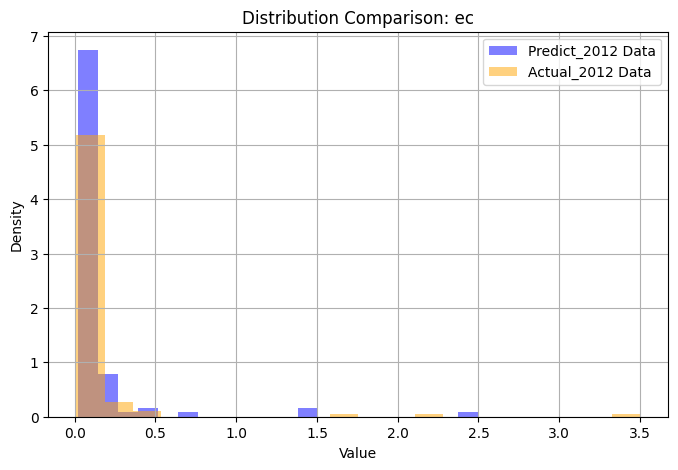

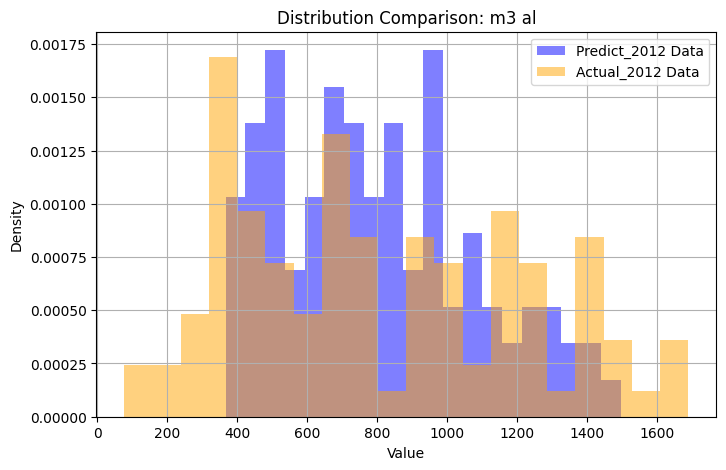

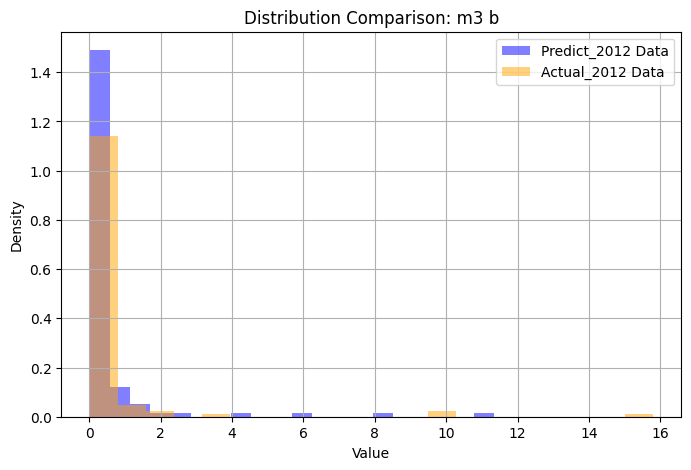

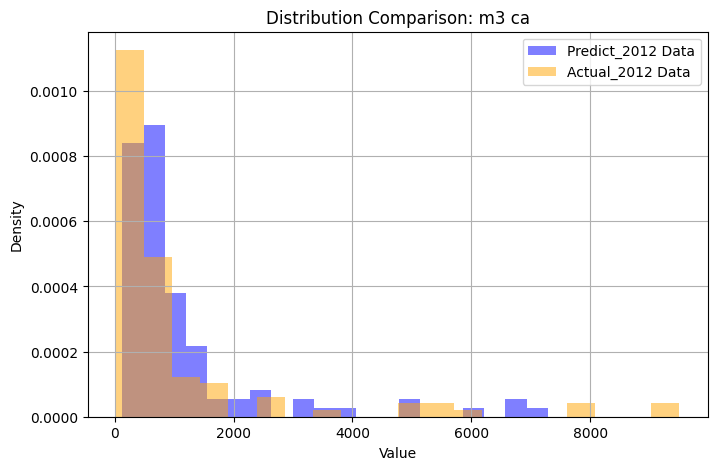

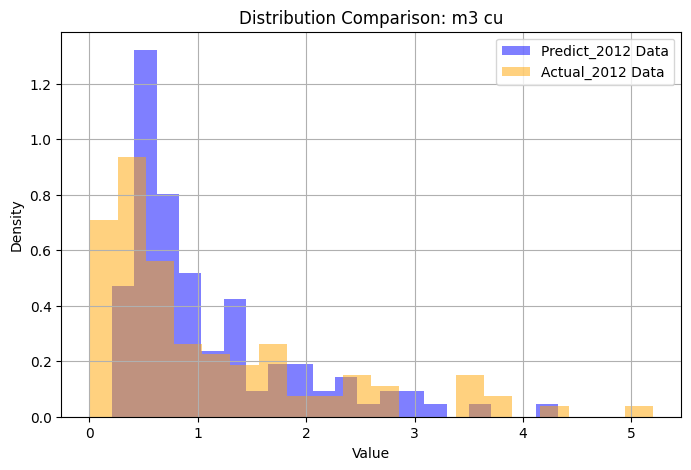

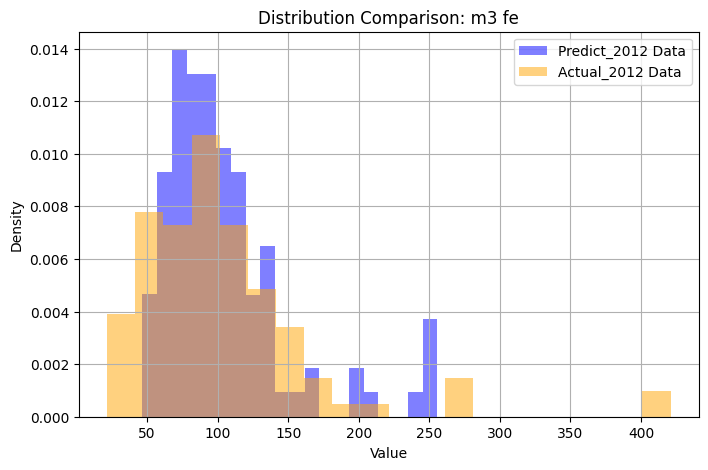

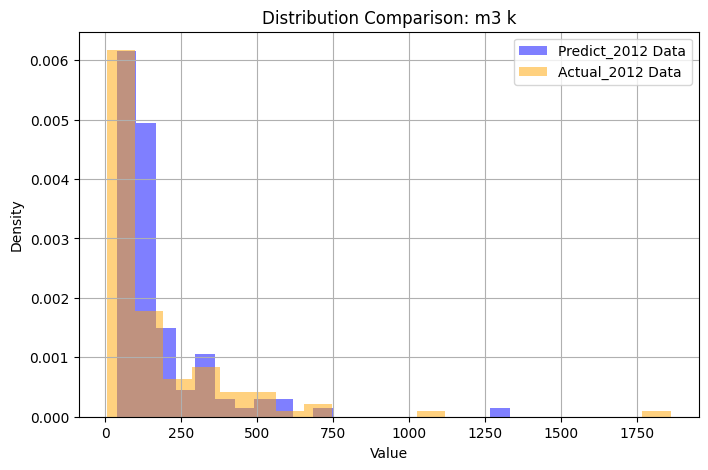

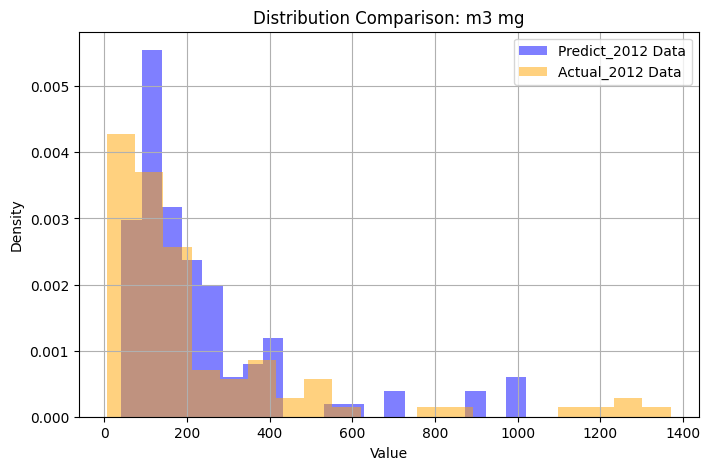

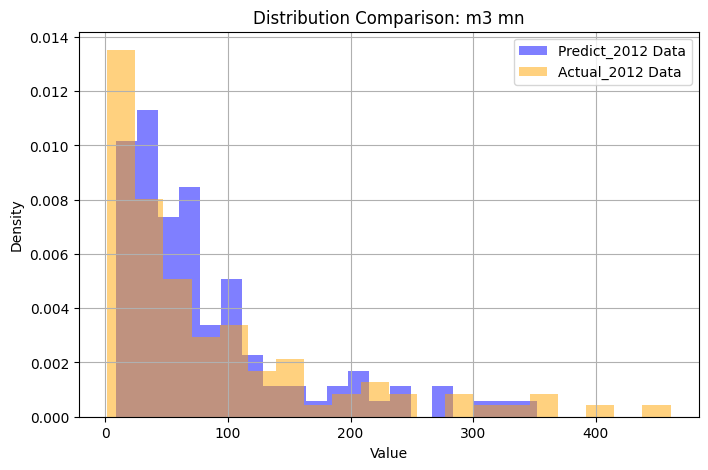

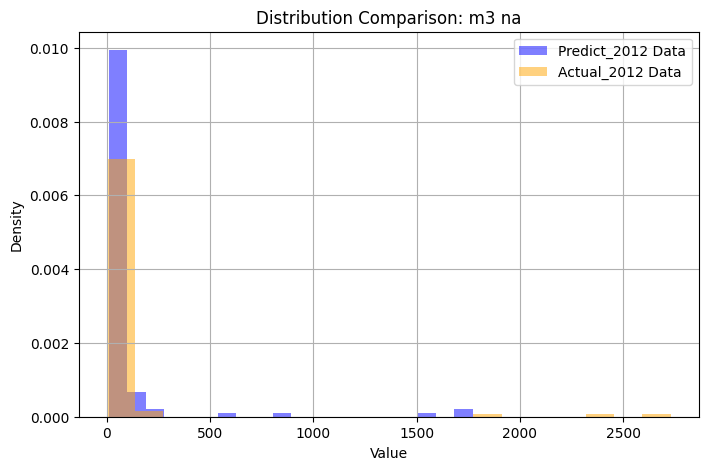

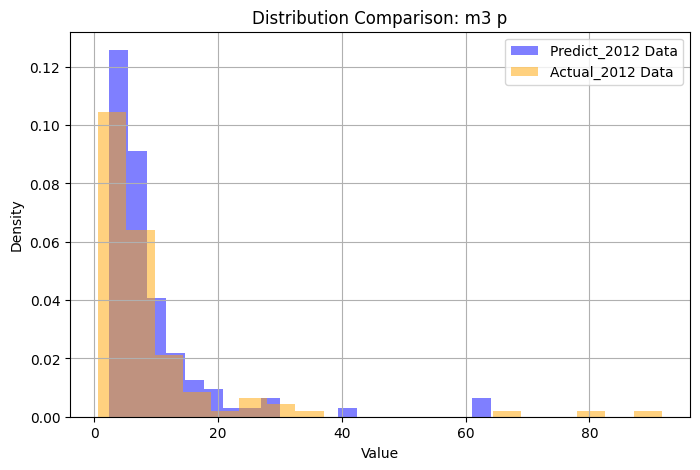

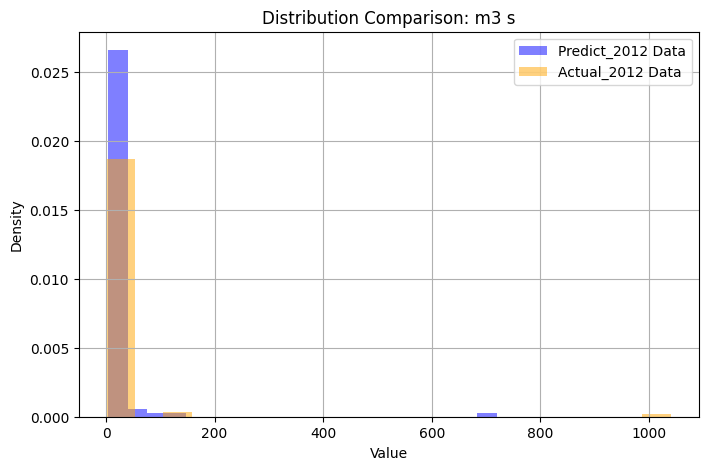

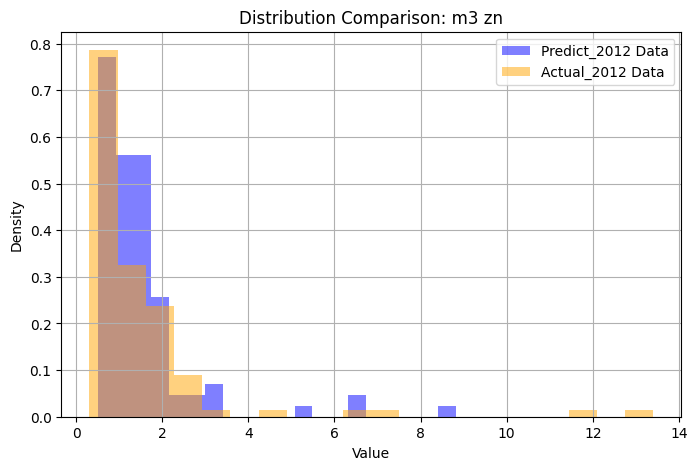

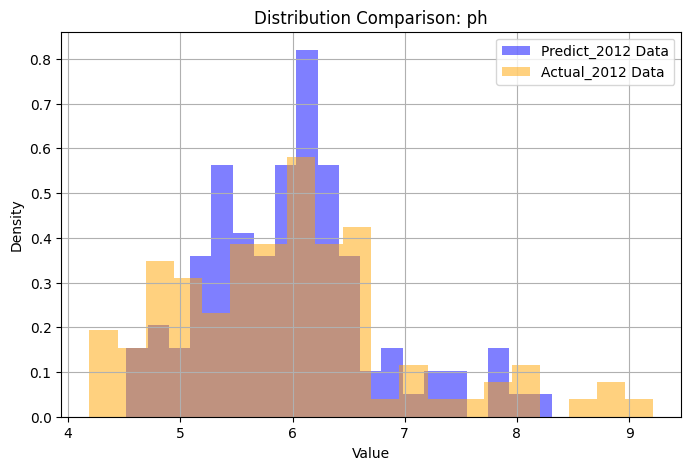

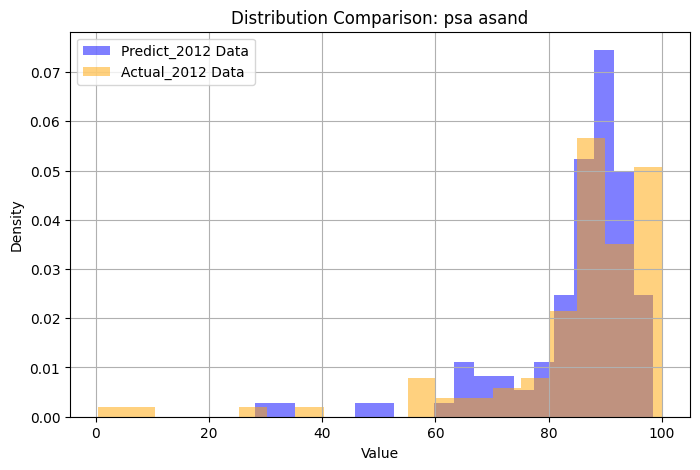

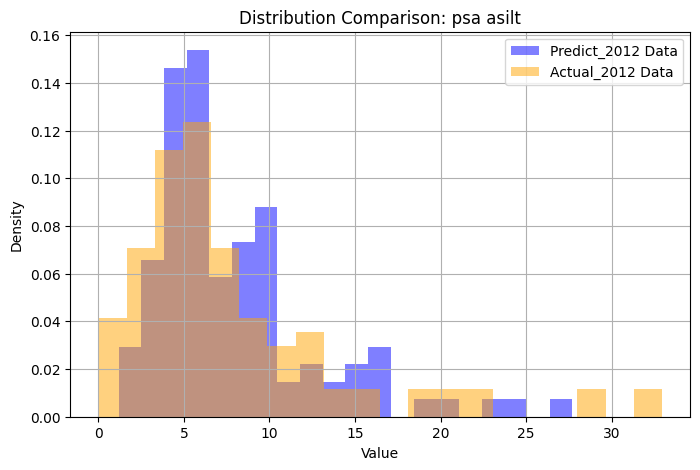

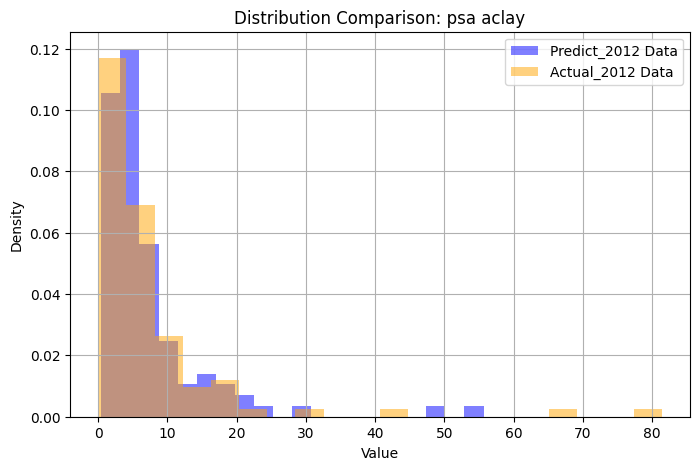

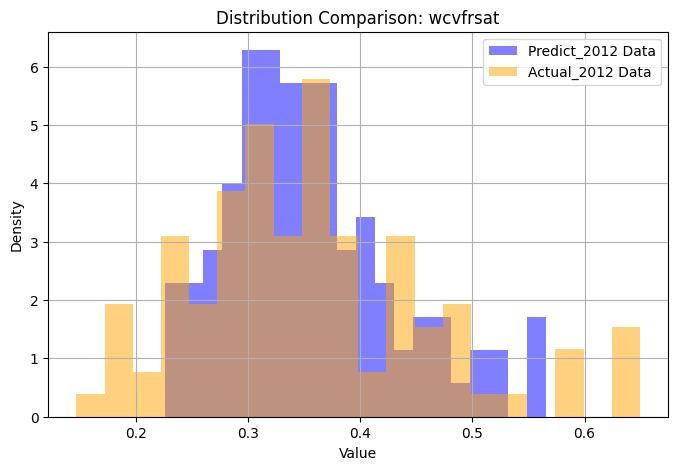

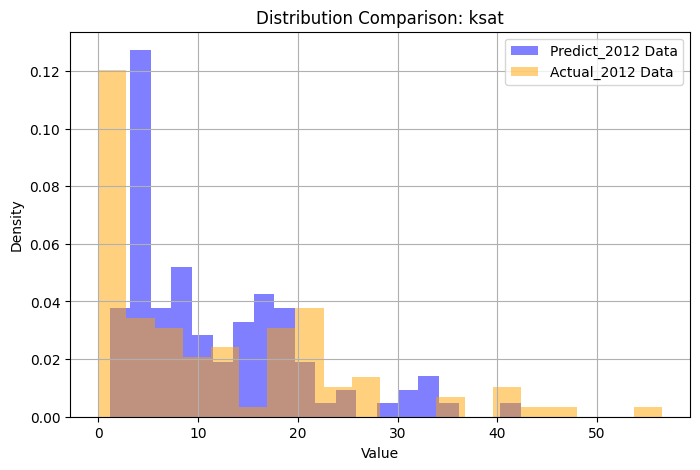

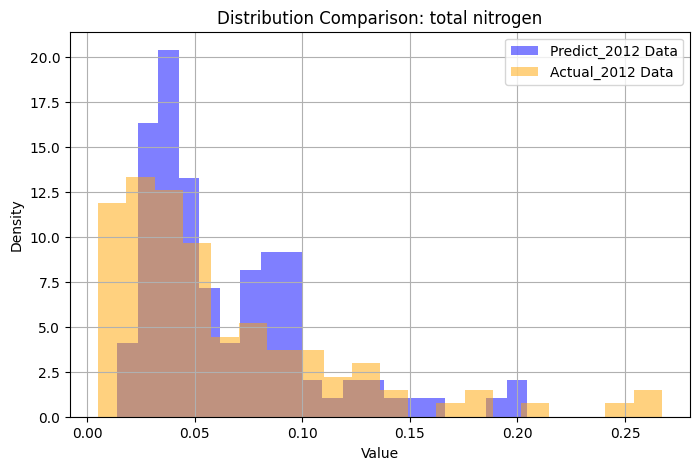

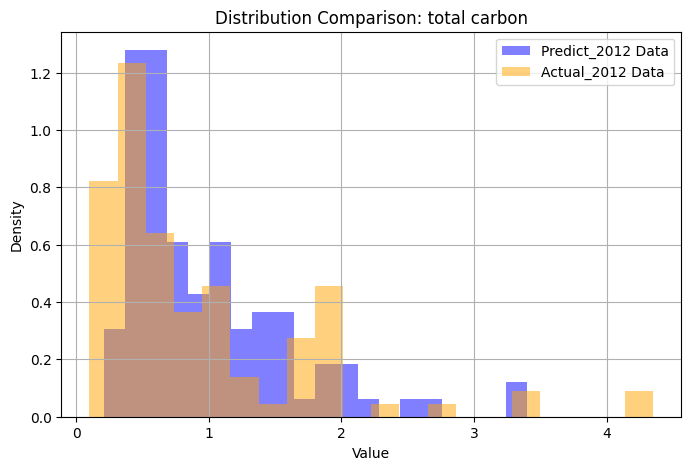

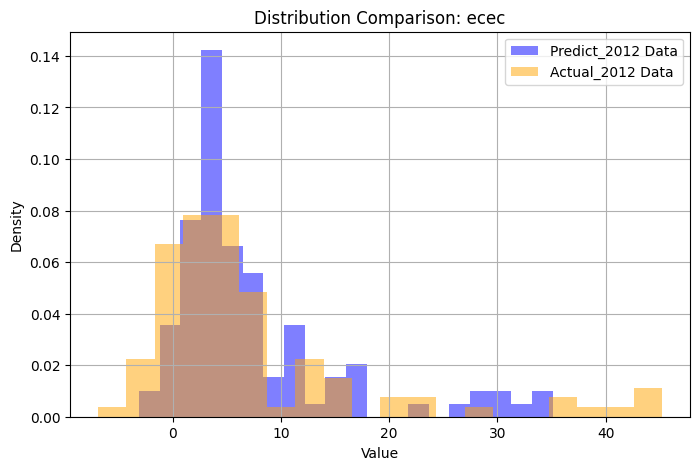

Comparison results have been saved to 'Comparison_Results.csv'
  Feature  Predict_2012 Mean  Actual_2012 Mean  Correlation  Absolute Error  \
0      ec           0.136701          0.137563     0.958738        0.000862   
1   m3 al         805.463823        805.029786     0.820359        0.434037   
2    m3 b           0.547200          0.558776     0.954218        0.011576   
3   m3 ca        1181.334619       1134.223495     0.960192       47.111124   
4   m3 cu           1.086495          1.081023     0.974691        0.005471   

   Percentage Error (%)  
0              0.626438  
1              0.053916  
2              2.071616  
3              4.153602  
4              0.506122  


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the target columns
target = ['EC', 'M3 Al', 'M3 B', 'M3 Ca', 'M3 Cu', 'M3 Fe', 'M3 K', 'M3 Mg', 'M3 Mn',
          'M3 Na', 'M3 P', 'M3 S', 'M3 Zn', 'PH', 'Psa asand', 'Psa asilt', 'Psa aclay',
          'Wcvfrsat', 'Ksat', 'Total nitrogen', 'Total carbon', 'ECEC']
target_2012 = [f'{col}_2012' for col in target]

# Load the datasets
soil_quality_csv_data = pd.read_csv('soil_quality_2012.csv')
soil_quality_csv_data = soil_quality_csv_data[target]  # Keep only target columns
quality_excel_df = pd.read_excel('Quality_2012_01.xlsx')
quality_excel_df = quality_excel_df[target_2012]  # Keep only target_2012 columns

# Standardize column names for comparison
quality_excel_df = quality_excel_df.rename(columns=lambda x: x.replace('_2012', '').strip().lower())
soil_quality_csv_data = soil_quality_csv_data.rename(columns=lambda x: x.strip().lower())

# Prepare overlapping features (in this case, already filtered to the target columns)
overlapping_features = quality_excel_df.columns.intersection(soil_quality_csv_data.columns)

# Compute statistical comparison (e.g., correlation, differences, errors)
comparison_results = pd.DataFrame({
    "Feature": overlapping_features,
    "Predict_2012 Mean": [quality_excel_df[col].mean() for col in overlapping_features],
    "Actual_2012 Mean": [soil_quality_csv_data[col].mean() for col in overlapping_features],
    "Correlation": [
        quality_excel_df[col].corr(soil_quality_csv_data[col]) if quality_excel_df[col].dtype in [float, int] and soil_quality_csv_data[col].dtype in [float, int] else None
        for col in overlapping_features
    ],
    "Absolute Error": [
        abs(quality_excel_df[col].mean() - soil_quality_csv_data[col].mean()) for col in overlapping_features
    ],
    "Percentage Error (%)": [
        abs((quality_excel_df[col].mean() - soil_quality_csv_data[col].mean()) / soil_quality_csv_data[col].mean()) * 100 if soil_quality_csv_data[col].mean() != 0 else None
        for col in overlapping_features
    ]
})

# Visualize distributions of overlapping features
for feature in comparison_results['Feature']:
    plt.figure(figsize=(8, 5))
    plt.hist(quality_excel_df[feature], bins=20, alpha=0.5, label='Predict_2012 Data', color='blue', density=True)
    plt.hist(soil_quality_csv_data[feature], bins=20, alpha=0.5, label='Actual_2012 Data', color='orange', density=True)
    plt.title(f'Distribution Comparison: {feature}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Save the results to a CSV file
comparison_results.to_csv("Comparison_Results.csv", index=False)
print("Comparison results have been saved to 'Comparison_Results.csv'")

# Display the first few rows of the results
print(comparison_results.head())


In [11]:
print(df.columns)

Index(['Acidified carbon_2012', 'Acidified nitrogen_2012', 'C % Inorg_2012',
       'C % Org_2012', 'ECEC_2012', 'EC_2012', 'Humidity_2012', 'Ksat_2012',
       'M3 Al_2012', 'M3 B_2012', 'M3 Ca_2012', 'M3 Cu_2012', 'M3 Fe_2012',
       'M3 K_2012', 'M3 Mg_2012', 'M3 Mn_2012', 'M3 Na_2012', 'M3 P_2012',
       'M3 S_2012', 'M3 Zn_2012', 'Month_2012', 'PH_2012', 'Psa aclay_2012',
       'Psa asand_2012', 'Psa asilt_2012', 'Temperature_2012',
       'Total carbon_2012', 'Total nitrogen_2012', 'Wcvfrairdry_2012',
       'Wcvfrsat_2012', 'Wind Speed_2012', 'Year_2012', 'r1h_2012',
       'r1h_avg_2012', 'rfh_2012', 'rfh_avg_2012'],
      dtype='object')


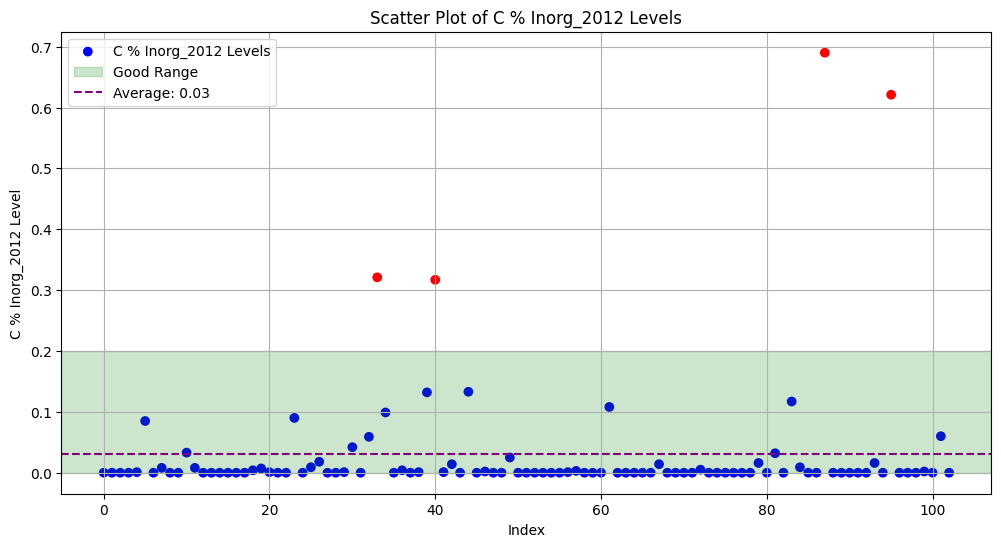

Average Value of C % Inorg_2012: 0.03
Classification Breakdown:
Normal C % Inorg_2012 Value in Soil




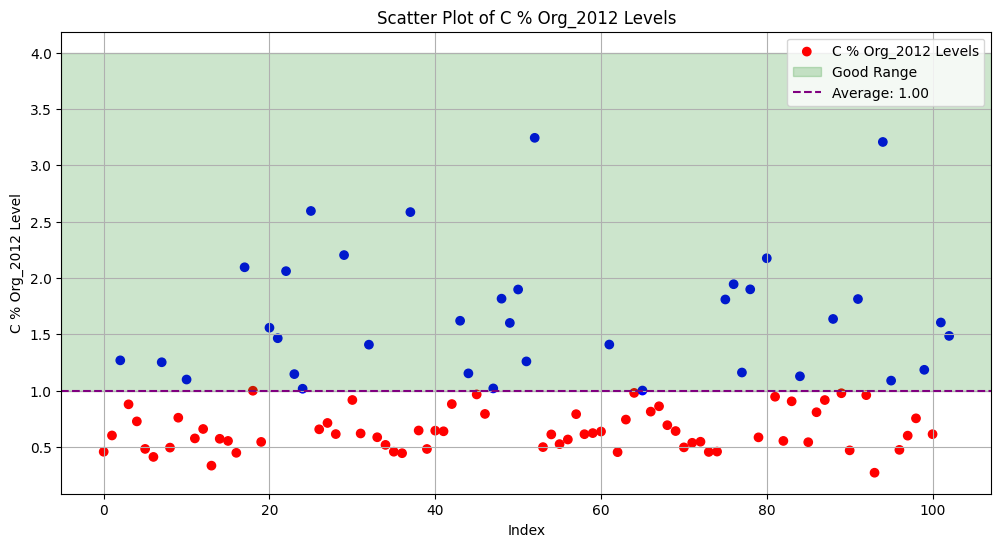

Average Value of C % Org_2012: 1.00
Classification Breakdown:
C % Org_2012 Deficient Soil




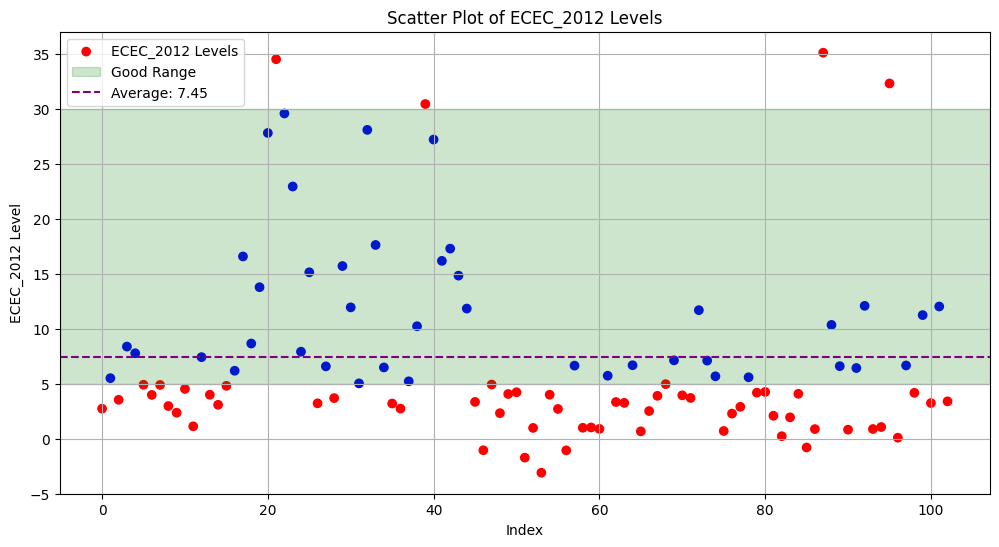

Average Value of ECEC_2012: 7.45
Classification Breakdown:
Normal ECEC_2012 Value in Soil




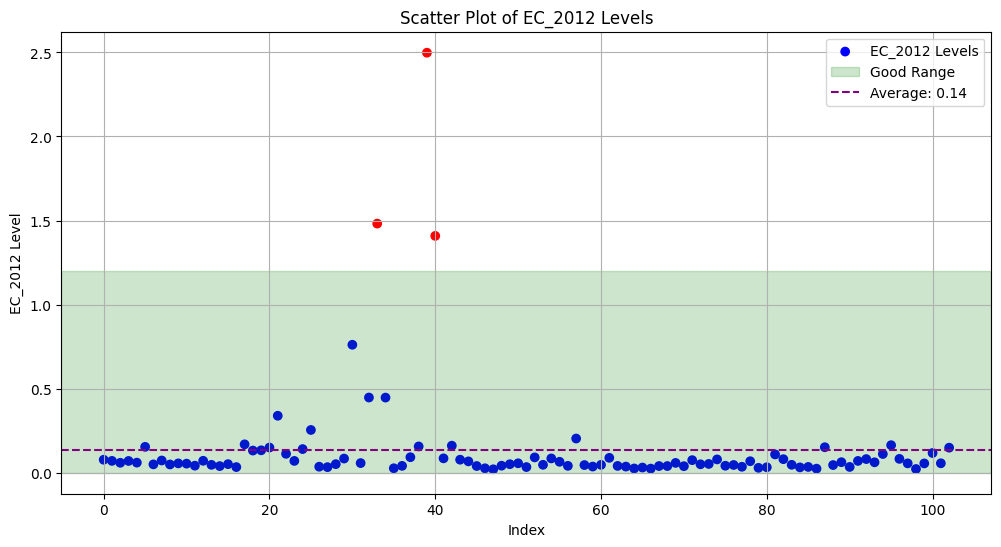

Average Value of EC_2012: 0.14
Classification Breakdown:
Normal EC_2012 Value in Soil




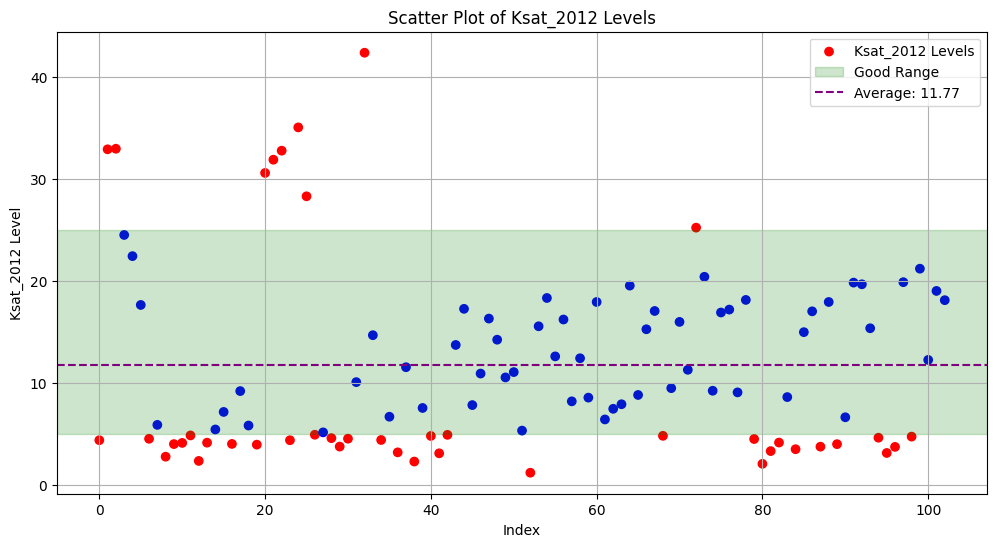

Average Value of Ksat_2012: 11.77
Classification Breakdown:
Normal Drainage Soil




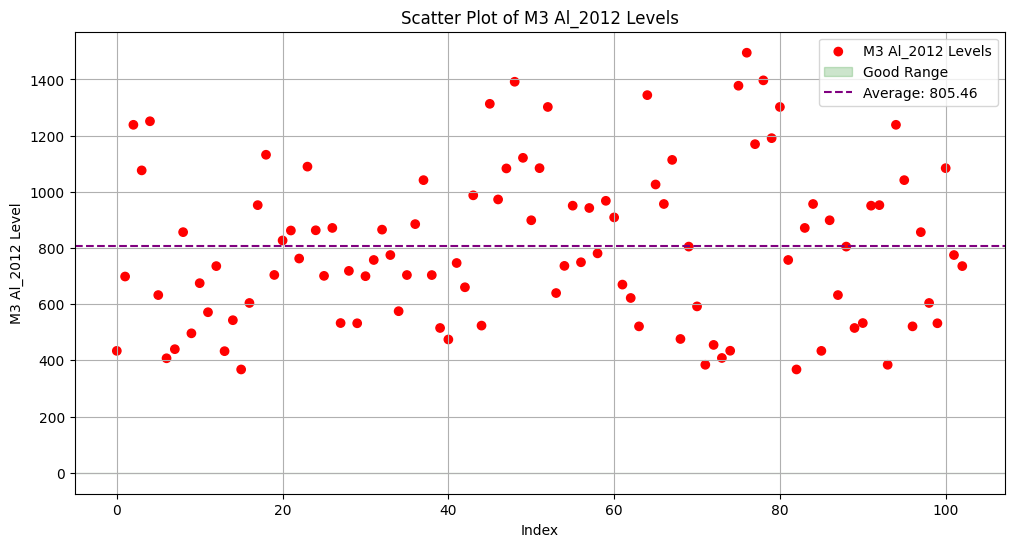

Average Value of M3 Al_2012: 805.46
Classification Breakdown:
M3 Al_2012 Toxic Soil




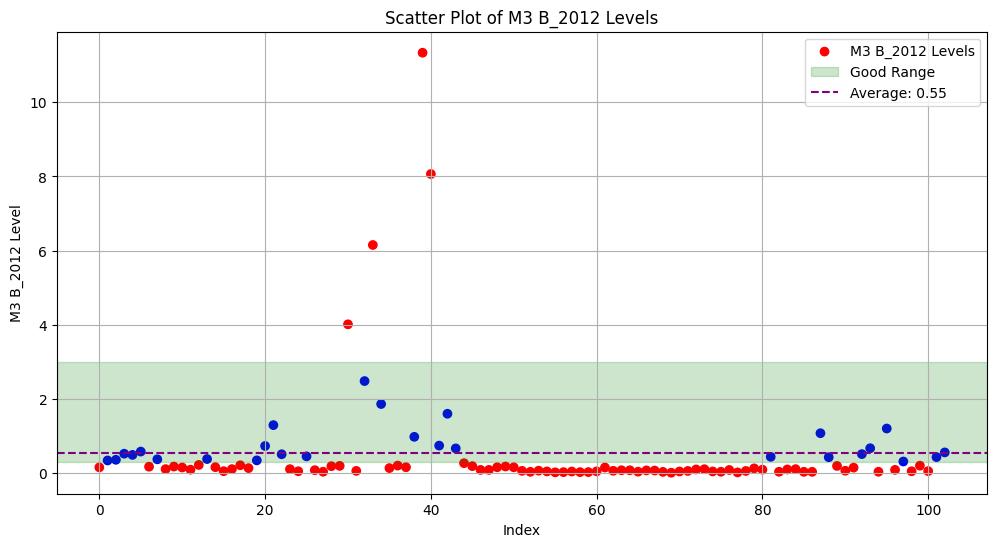

Average Value of M3 B_2012: 0.55
Classification Breakdown:
Normal M3 B_2012 Value in Soil




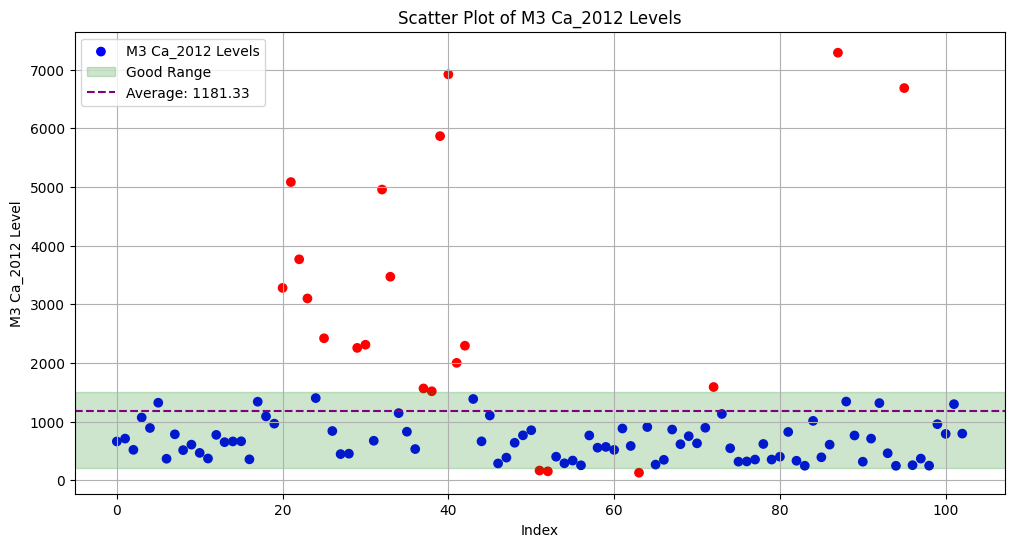

Average Value of M3 Ca_2012: 1181.33
Classification Breakdown:
Normal M3 Ca_2012 Value in Soil




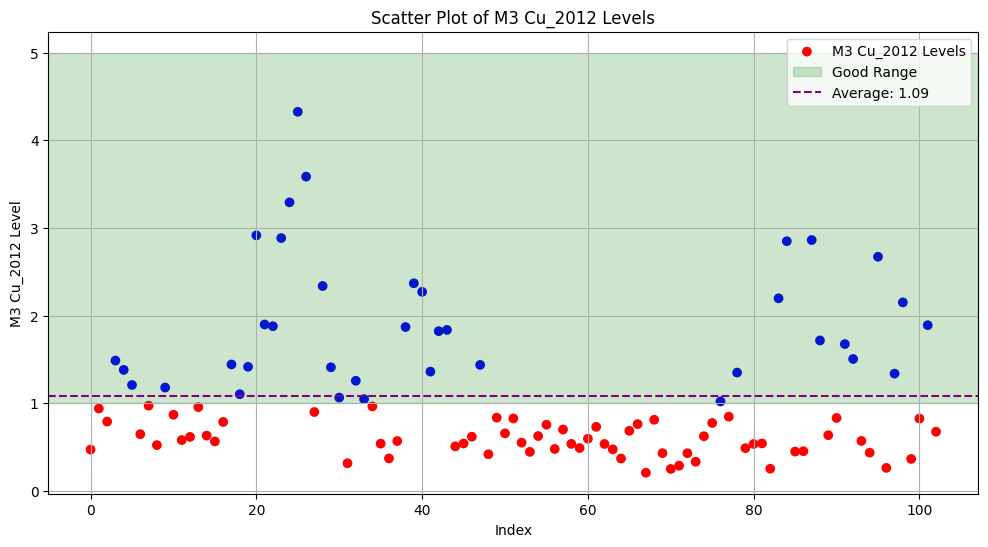

Average Value of M3 Cu_2012: 1.09
Classification Breakdown:
Normal M3 Cu_2012 Value in Soil




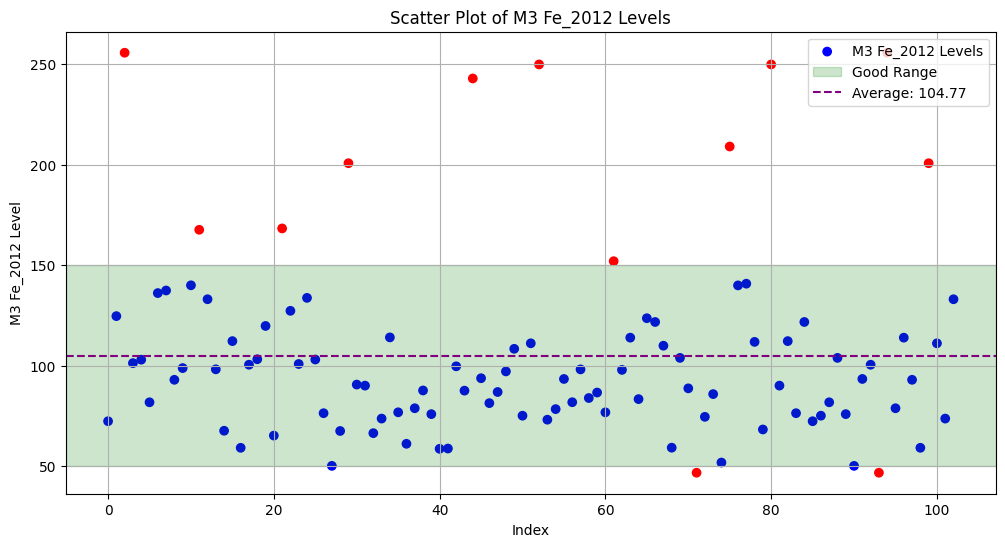

Average Value of M3 Fe_2012: 104.77
Classification Breakdown:
Normal M3 Fe_2012 Value in Soil




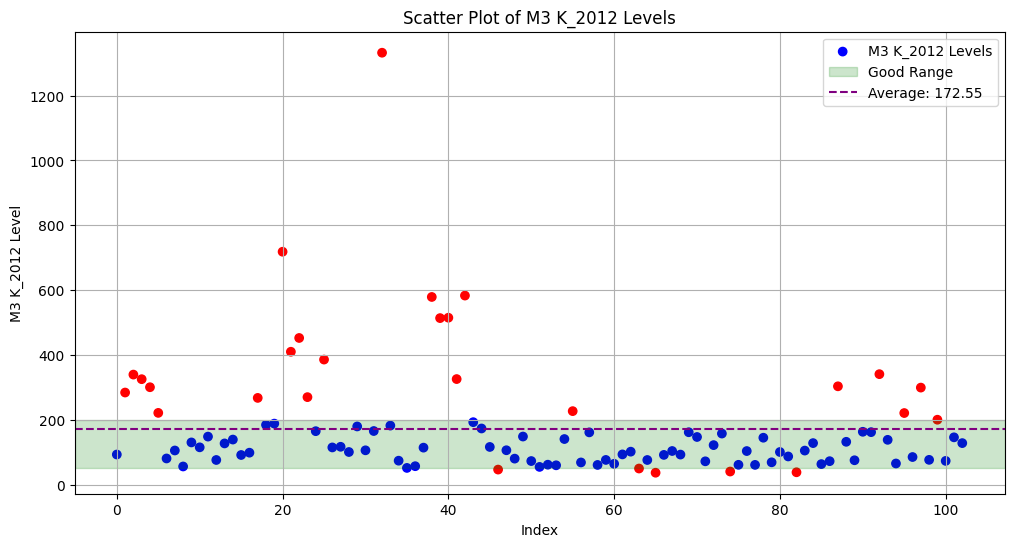

Average Value of M3 K_2012: 172.55
Classification Breakdown:
Normal M3 K_2012 Value in Soil




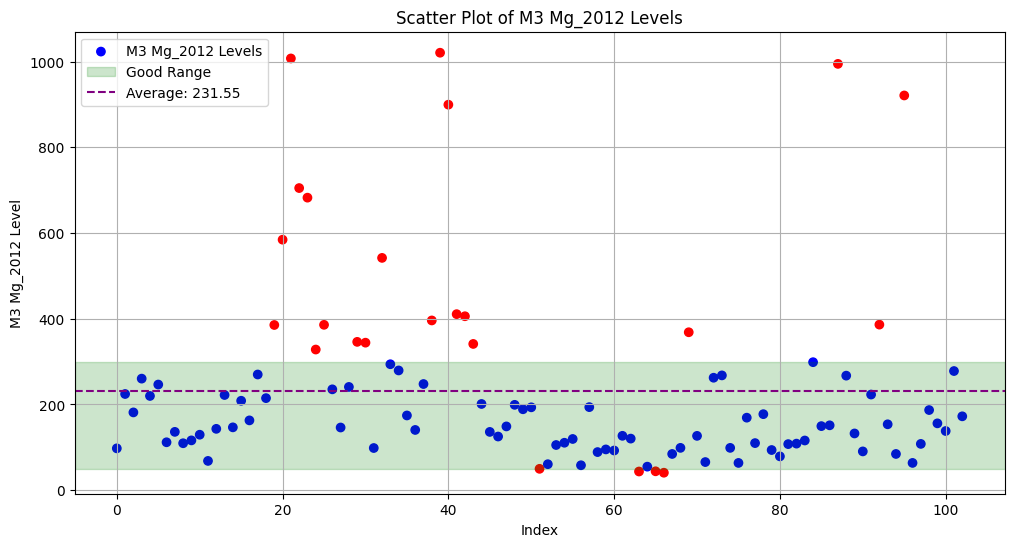

Average Value of M3 Mg_2012: 231.55
Classification Breakdown:
Normal M3 Mg_2012 Value in Soil




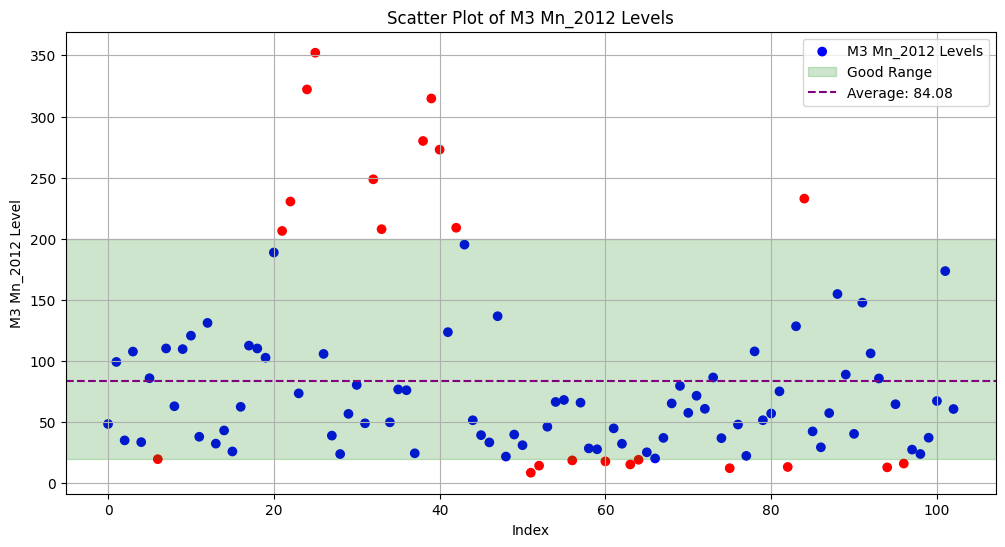

Average Value of M3 Mn_2012: 84.08
Classification Breakdown:
Normal M3 Mn_2012 Value in Soil




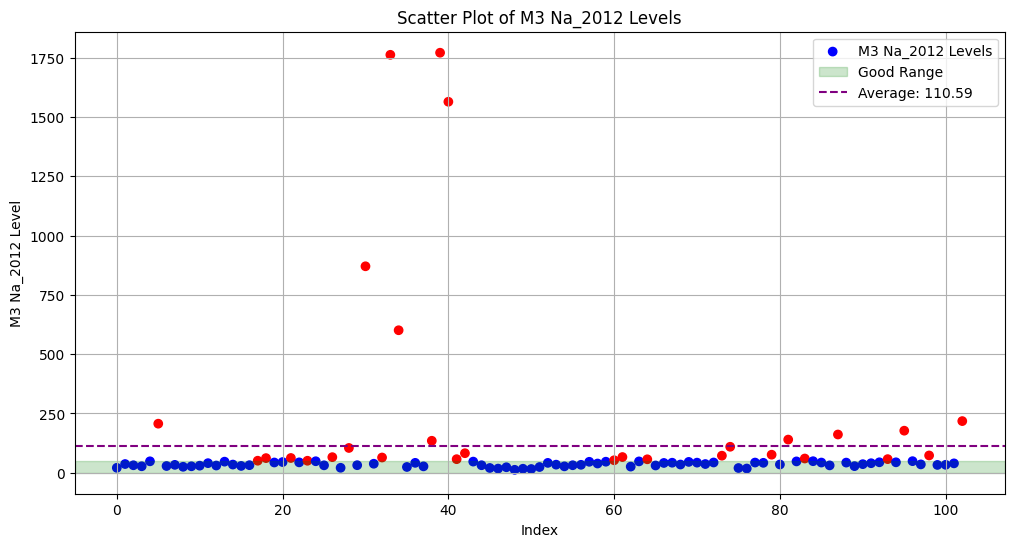

Average Value of M3 Na_2012: 110.59
Classification Breakdown:
M3 Na_2012 Toxic Soil




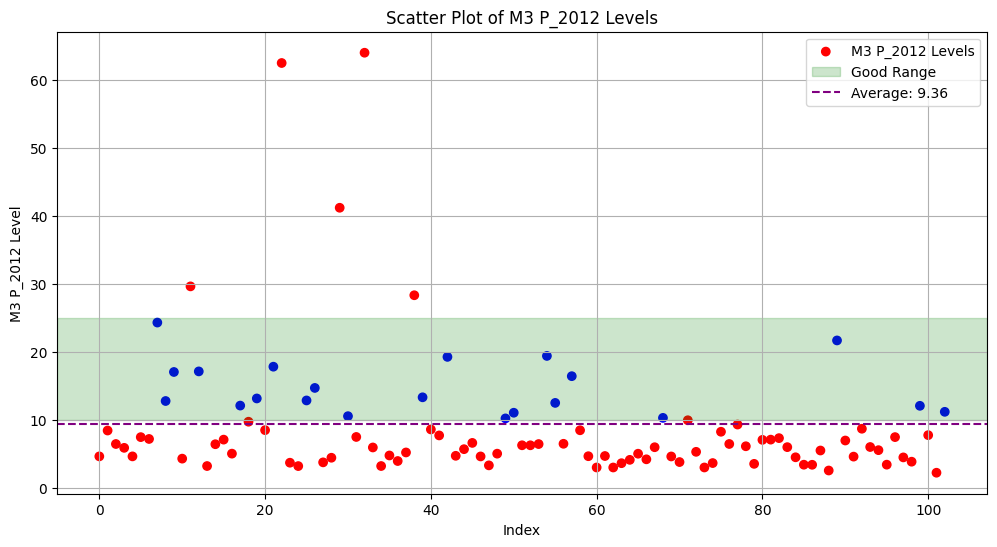

Average Value of M3 P_2012: 9.36
Classification Breakdown:
M3 P_2012 Deficient Soil




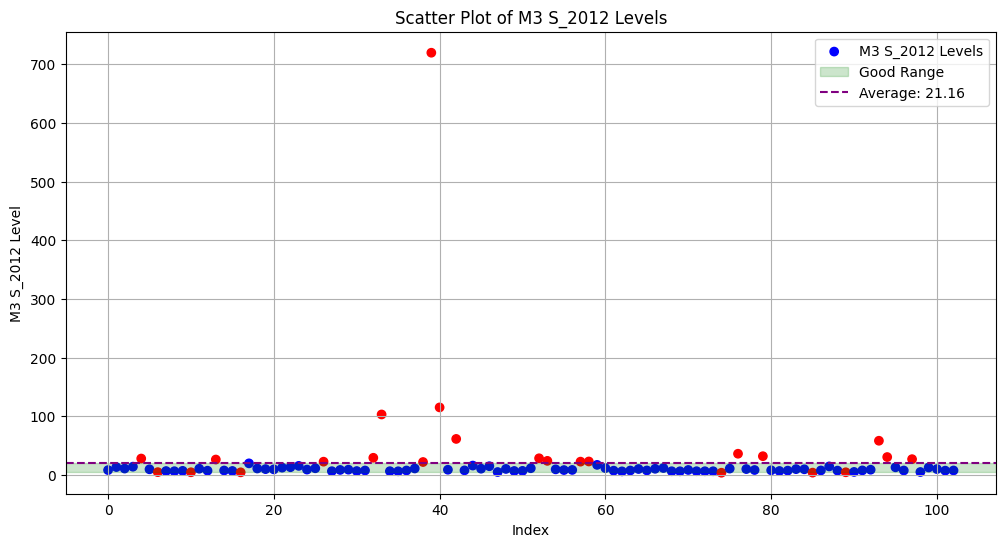

Average Value of M3 S_2012: 21.16
Classification Breakdown:
M3 S_2012 Toxic Soil




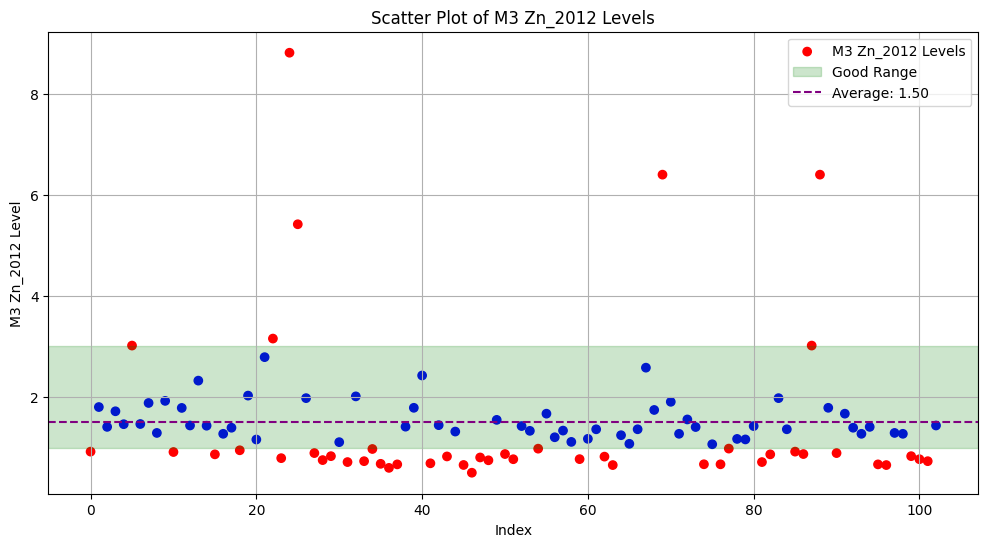

Average Value of M3 Zn_2012: 1.50
Classification Breakdown:
Normal M3 Zn_2012 Value in Soil




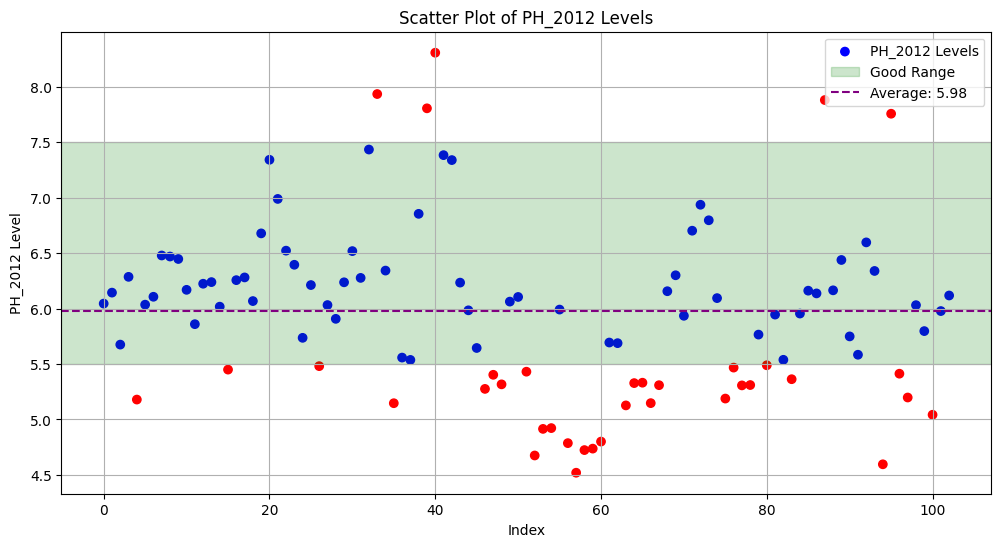

Average Value of PH_2012: 5.98
Classification Breakdown:
Neutral Soil




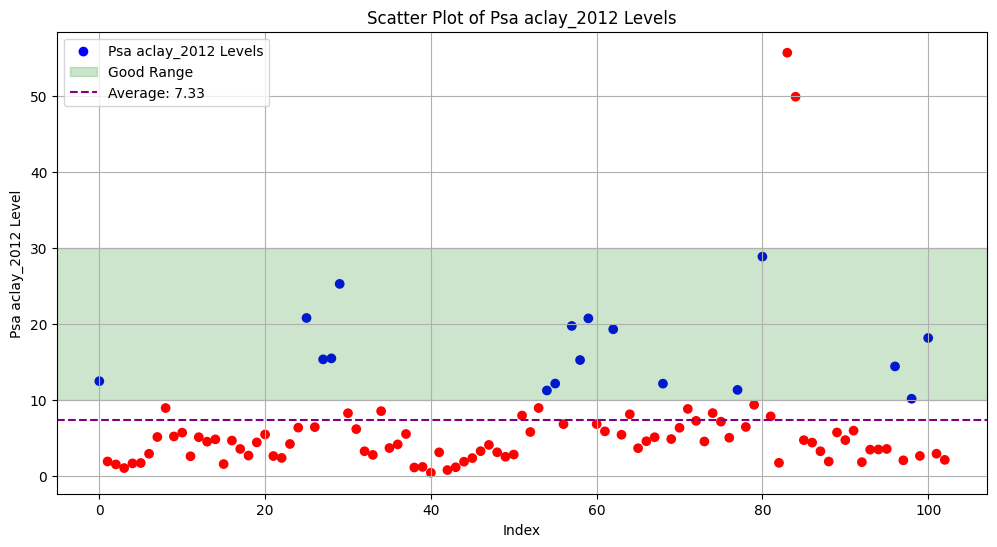

Average Value of Psa aclay_2012: 7.33
Classification Breakdown:
Poor Drainage Soil




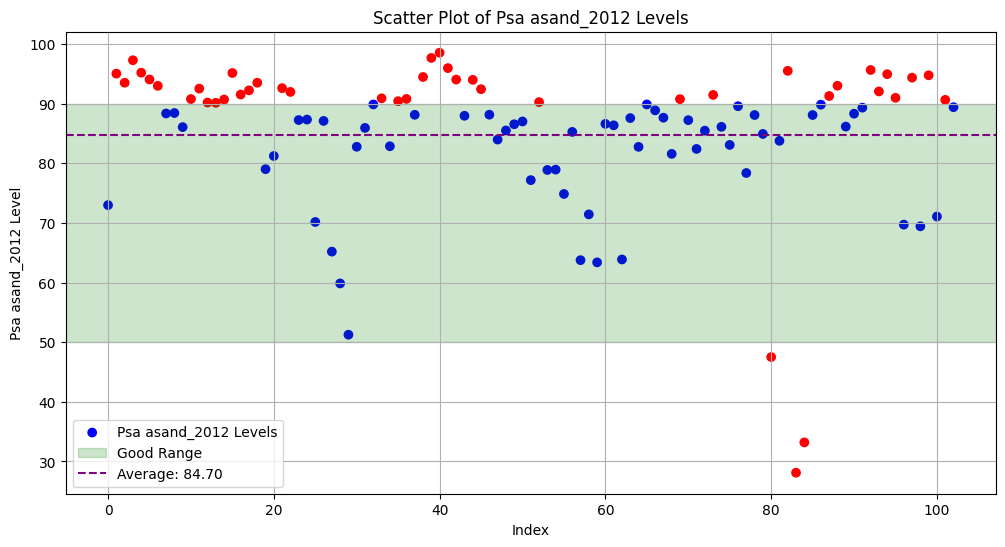

Average Value of Psa asand_2012: 84.70
Classification Breakdown:
Good Fertility and Drainage in Soil




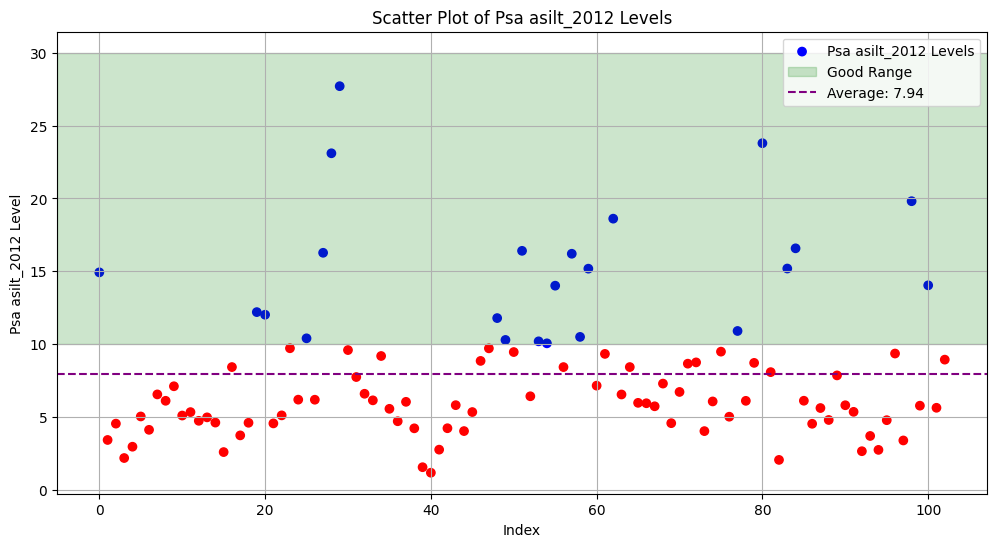

Average Value of Psa asilt_2012: 7.94
Classification Breakdown:
Low Fertility in Soil




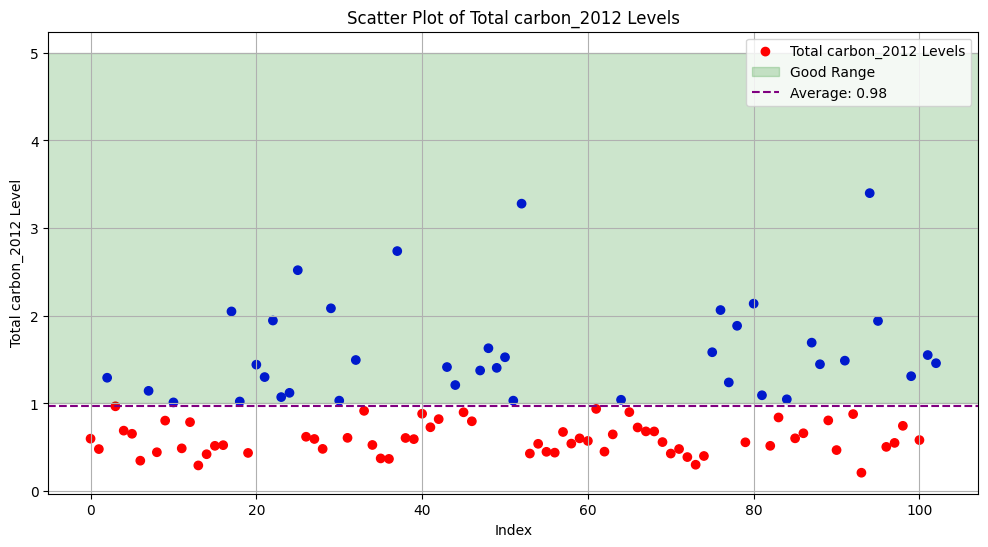

Average Value of Total carbon_2012: 0.98
Classification Breakdown:
Total carbon_2012 Deficient Soil




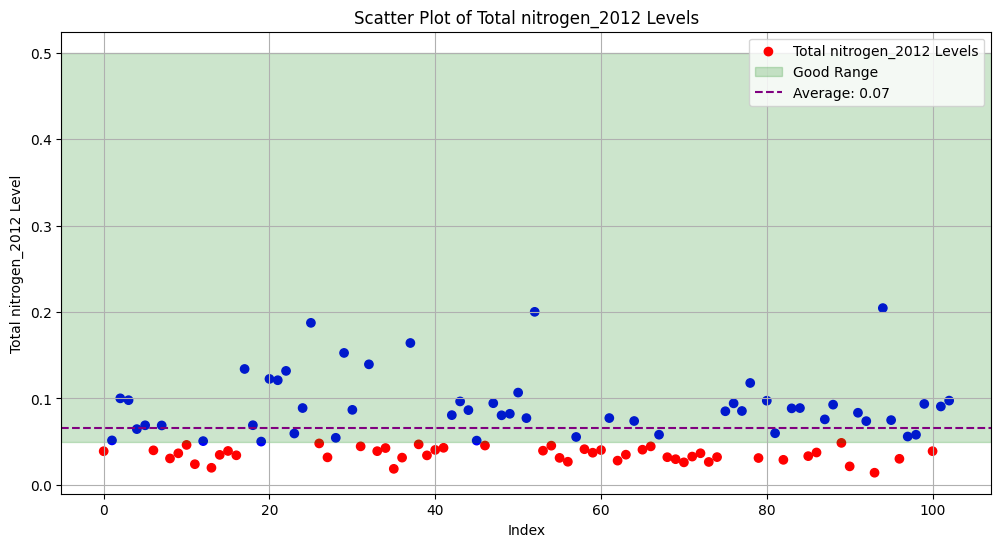

Average Value of Total nitrogen_2012: 0.07
Classification Breakdown:
Normal Total nitrogen_2012 Value in Soil




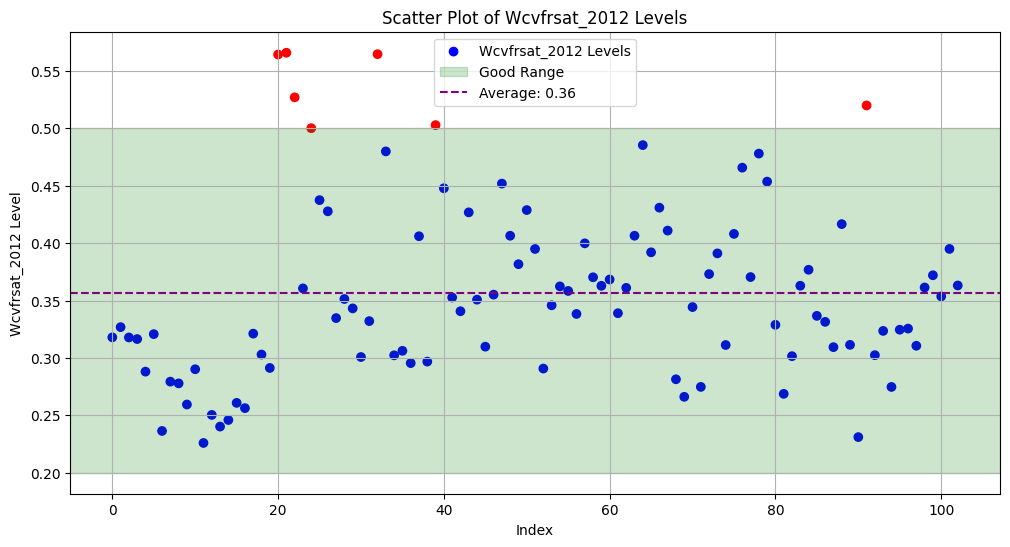

Average Value of Wcvfrsat_2012: 0.36
Classification Breakdown:
Normal Water Saturation in Soil




In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame - Replace with your actual data
# df = pd.read_csv("your_dataset.csv")

# Features and Good Ranges
features = ['C % Inorg_2012',
       'C % Org_2012', 'ECEC_2012', 'EC_2012', 'Ksat_2012',
       'M3 Al_2012', 'M3 B_2012', 'M3 Ca_2012', 'M3 Cu_2012', 'M3 Fe_2012',
       'M3 K_2012', 'M3 Mg_2012', 'M3 Mn_2012', 'M3 Na_2012', 'M3 P_2012',
       'M3 S_2012', 'M3 Zn_2012', 'PH_2012', 'Psa aclay_2012',
       'Psa asand_2012', 'Psa asilt_2012',
       'Total carbon_2012', 'Total nitrogen_2012',
       'Wcvfrsat_2012']

good_ranges = {
    'M3 Al_2012': (0.0, 0.5),
    'M3 B_2012': (0.3, 3.0),
    'M3 Ca_2012': (200.0, 1500.0),
    'M3 Cu_2012':(1.0,5.0),
    'M3 Fe_2012':(50.0,150.0),
    'M3 K_2012':(50.0,200.0),
    'M3 Mg_2012':(50.0,300.0),
    'M3 Mn_2012':(20.0,200.0),
    'M3 Na_2012':(0.0,50.0),
    'M3 P_2012':(10.0,25.0),
    'M3 S_2012':(5.0,20.0),
    'M3 Zn_2012':(1.0,3.0),
    'PH_2012':(5.5,7.5),
    'Psa asand_2012':(50.0,90.0),
    'Psa asilt_2012':(10.0,30.0),
    'Psa aclay_2012':(10.0,30.0),
    'Wcvfrsat_2012':(0.2,0.5),
    'Ksat_2012':(5.0,25.0),
    'Total nitrogen_2012':(0.05,0.5),
    'Total carbon_2012':(1.0,5.0),
    'ECEC_2012':(5.0,30.0),
    'EC_2012':(0.0,1.2),
    'C % Inorg_2012':(0.0,0.2),
    'C % Org_2012':(1.0,4.0)
}

# Function to classify soil levels
def classify_soil(feature,value, good_min, good_max):
  if feature in ['C % Inorg_2012',
       'C % Org_2012', 'ECEC_2012', 'EC_2012',
       'M3 Al_2012', 'M3 B_2012', 'M3 Ca_2012', 'M3 Cu_2012', 'M3 Fe_2012',
       'M3 K_2012', 'M3 Mg_2012', 'M3 Mn_2012', 'M3 Na_2012', 'M3 P_2012',
       'M3 S_2012', 'M3 Zn_2012','Total carbon_2012', 'Total nitrogen_2012',
       ]:

    if value < good_min:  # Between 80% and 100% of minimum
        return f"{feature} Deficient Soil"
    elif good_min <= value <= good_max:  # Within good range
        return f"Normal {feature} Value in Soil"
    else:  # Greater than 120% of max
        return f"{feature} Toxic Soil"
  if feature in ['Ksat_2012','Psa aclay_2012']:
      if value < good_min:  # Between 80% and 100% of minimum
          return f"Poor Drainage Soil"
      elif good_min <= value <= good_max:  # Within good range
          return f"Normal Drainage Soil"
      else:  # Greater than 120% of max
          return f"Rapid Water Movement in Soil"
  if feature=='PH_2012':
      if value < good_min:  # Between 80% and 100% of minimum
          return f"Acidic Soil"
      elif good_min <= value <= good_max:  # Within good range
          return f"Neutral Soil"
      else:  # Greater than 120% of max
          return f"Alkaline Soil"
  if feature=='Wcvfrsat_2012':
      if value < good_min:  # Between 80% and 100% of minimum
          return f"Low Water Saturation in Soil"
      elif good_min <= value <= good_max:  # Within good range
          return f"Normal Water Saturation in Soil"
      else:  # Greater than 120% of max
          return f"High Water Saturation in Soil"
  if feature=='Psa asilt_2012':
      if value < good_min:  # Between 80% and 100% of minimum
          return f"Low Fertility in Soil"
      elif good_min <= value <= good_max:  # Within good range
          return f"Good Fertility in Soil"
      else:  # Greater than 120% of max
          return f"High Fertlity But Poor Drainange Soil"
  if feature=='Psa asand_2012':
      if value < good_min:  # Between 80% and 100% of minimum
          return f"Low Fertility and Poor Drainange in Soil"
      elif good_min <= value <= good_max:  # Within good range
          return f"Good Fertility and Drainage in Soil"
      else:  # Greater than 120% of max
          return f"High Fertlity Soil"
# Create scatter plots and calculate averages
for feature in features:
    values = df[feature]
    indices = np.arange(len(values))
    good_min, good_max = good_ranges[feature]

    # Determine classification and color of each value
    classifications = [classify_soil(feature,val, good_min, good_max) for val in values]
    colors = ['blue' if good_min <= val <= good_max else 'red' for val in values]
    # Calculate average
    avg_value = np.mean(values)

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.scatter(indices, values, c=colors, label=f'{feature} Levels')

    # Highlight the good range using a shaded region
    plt.axhspan(good_min, good_max, color='green', alpha=0.2, label='Good Range')
    plt.axhline(avg_value, color='purple', linestyle='--', label=f'Average: {avg_value:.2f}')

    # Add labels and title
    plt.title(f"Scatter Plot of {feature} Levels")
    plt.xlabel("Index")
    plt.ylabel(f"{feature} Level")
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

    # Print average and classification breakdown
    print(f"Average Value of {feature}: {avg_value:.2f}")
    print("Classification Breakdown:")
    # for category in ["Deficient Soil", "Slightly Deficient Soil", "Normal Value in Soil",
    #                  "Slightly Toxic Soil", "Toxic Soil"]:
    print(classify_soil(feature,avg_value,good_min,good_max))
    print("\n")


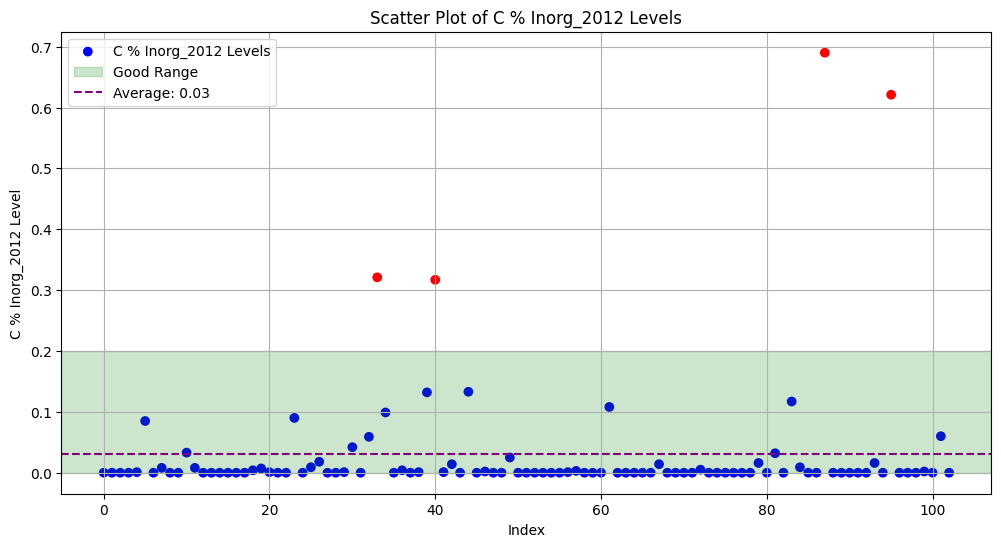

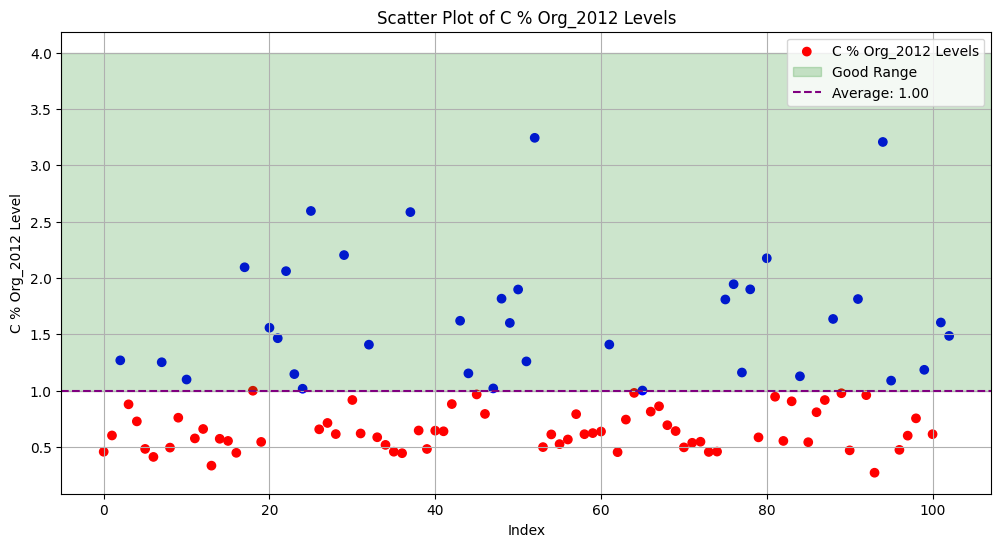

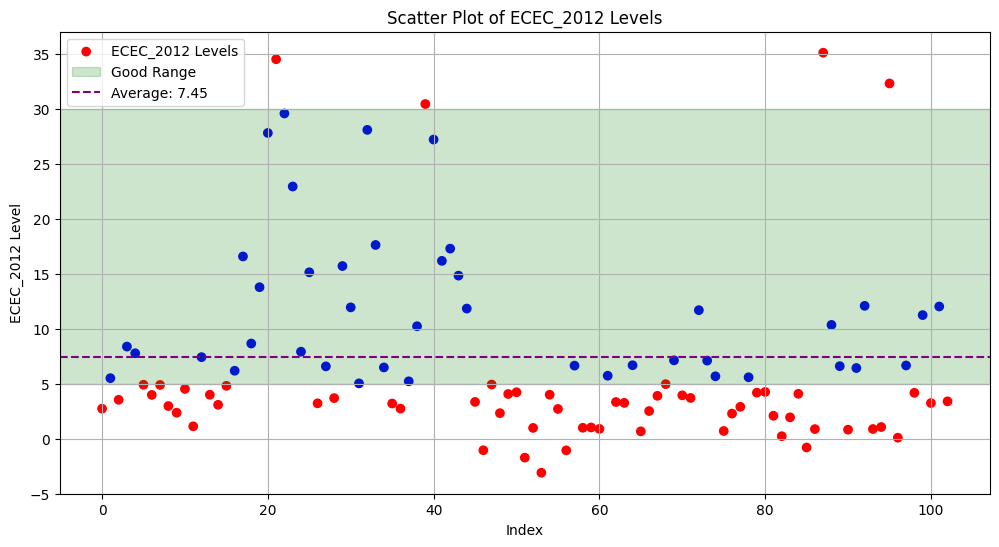

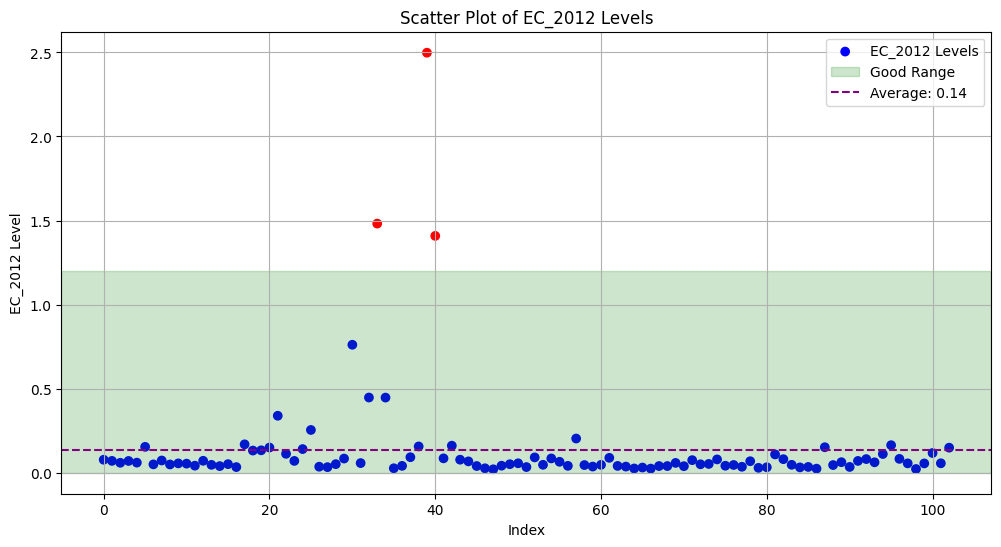

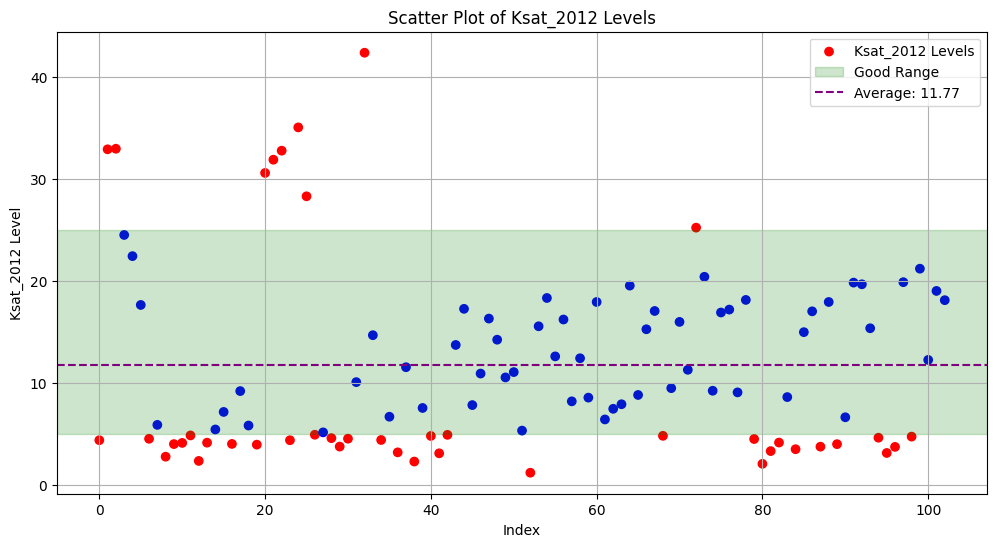

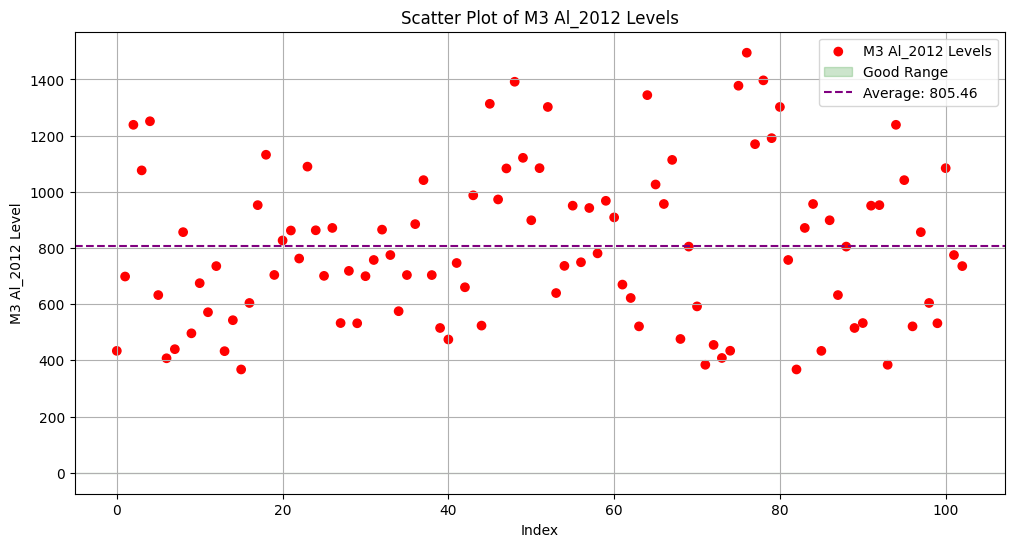

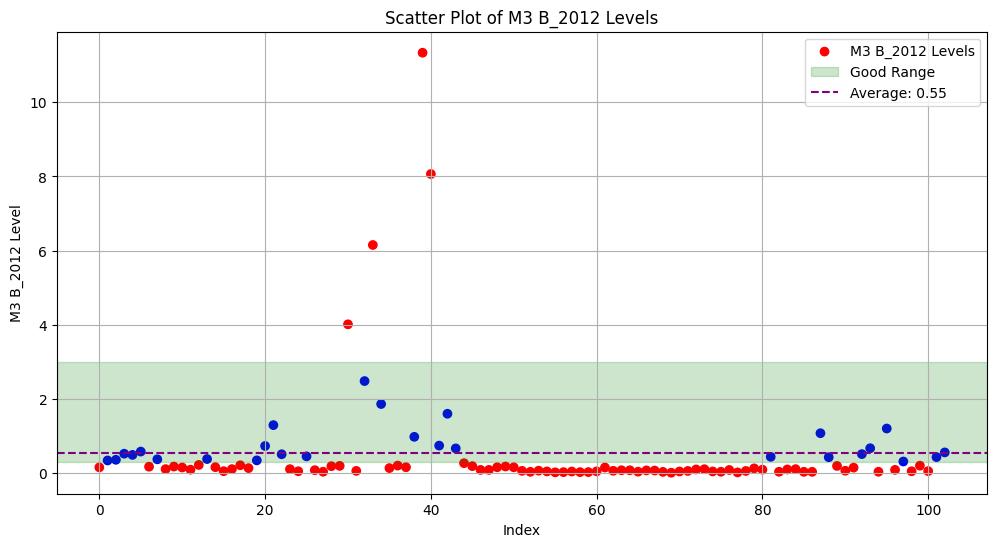

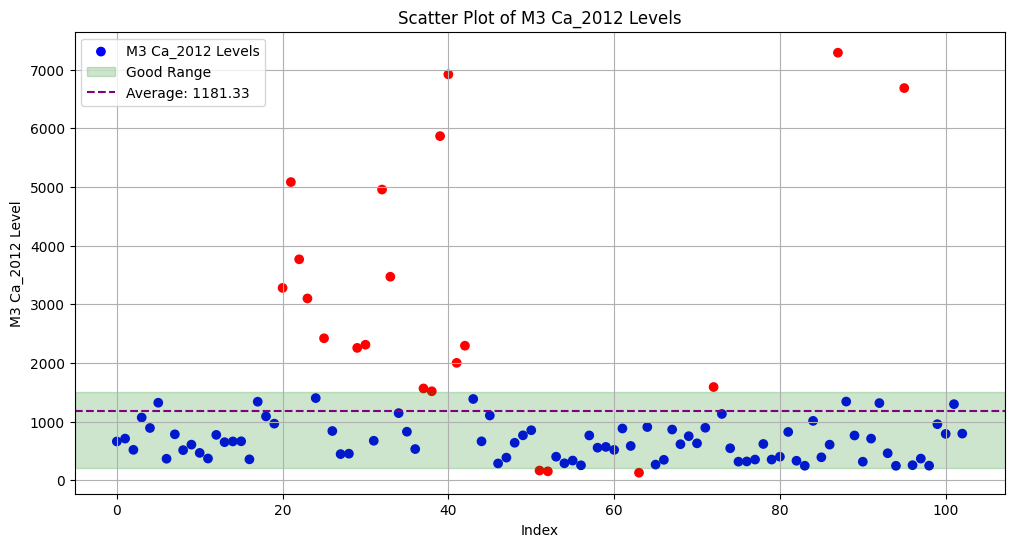

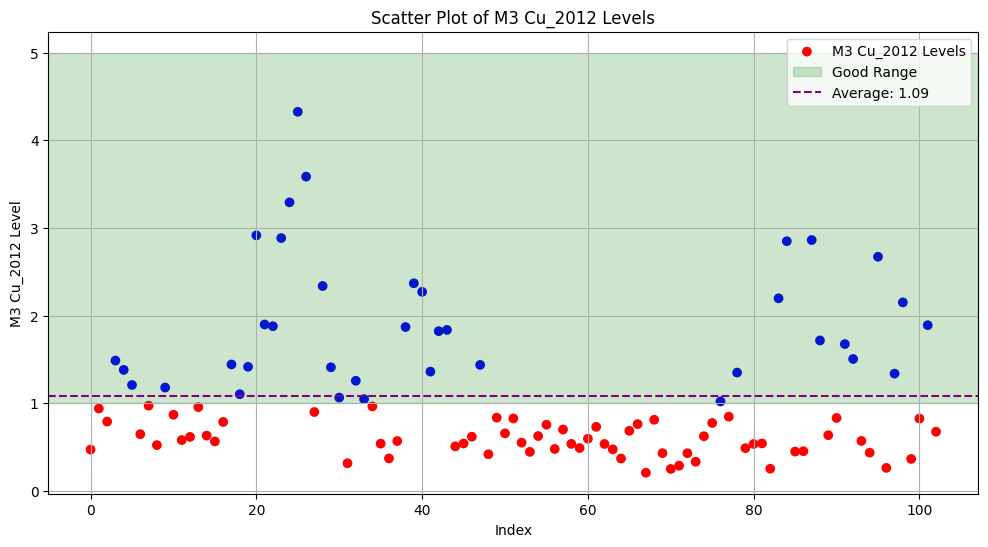

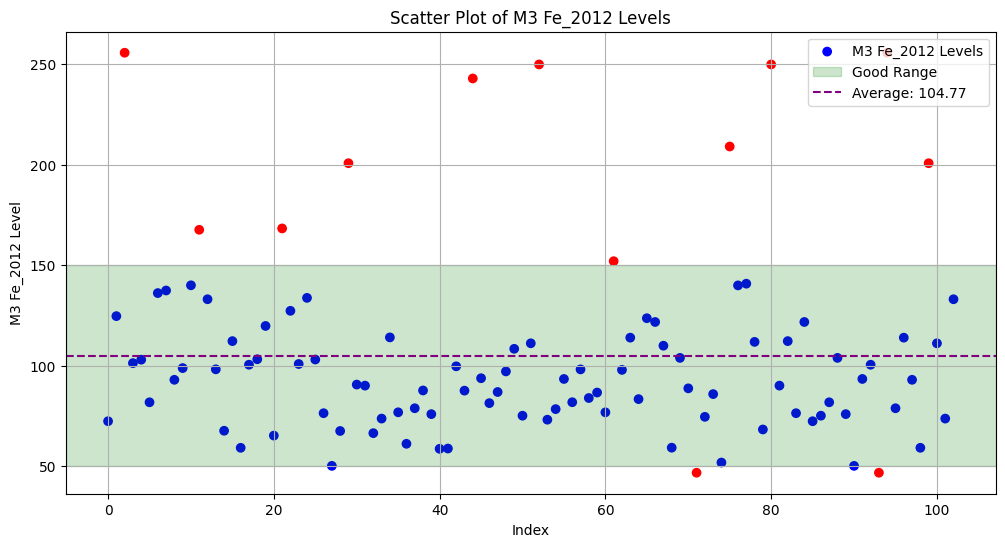

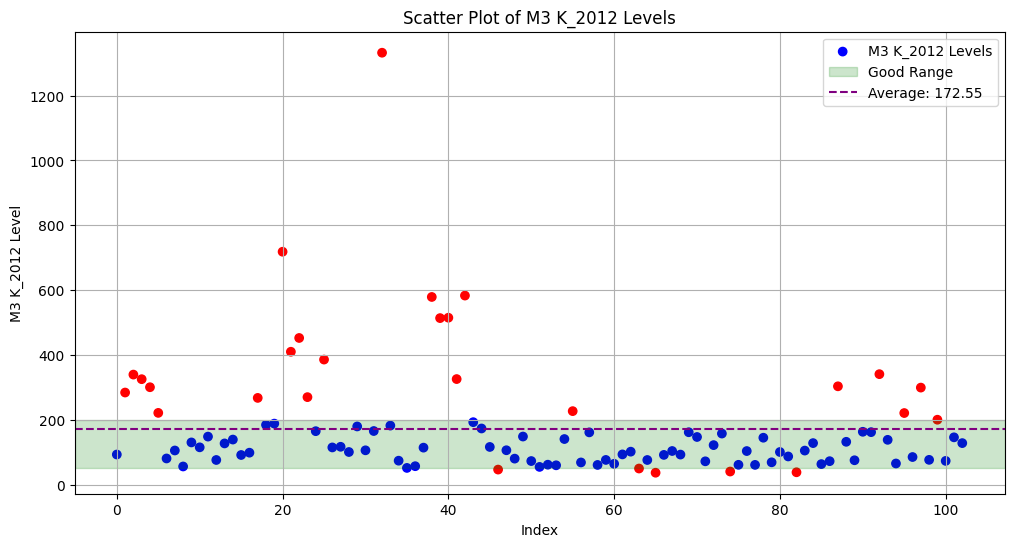

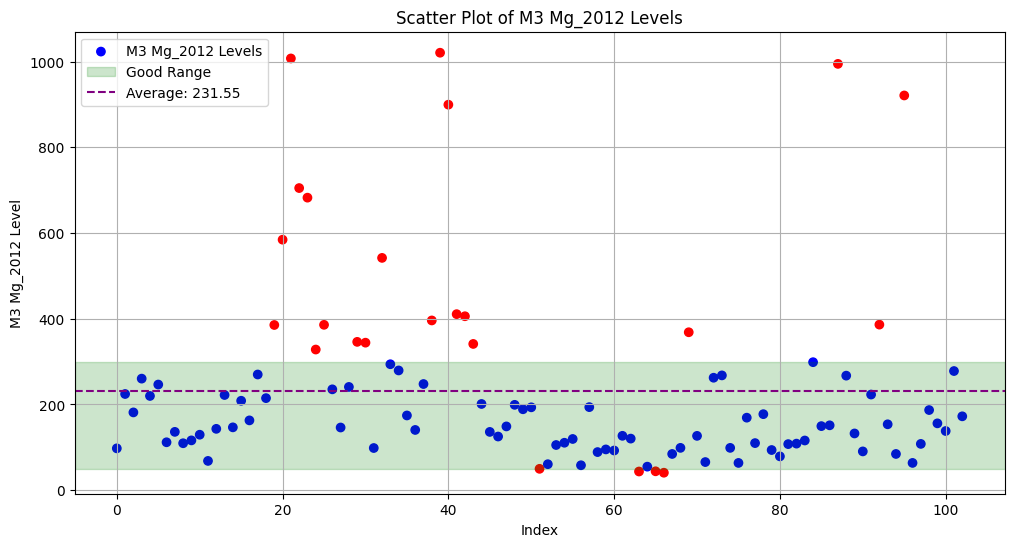

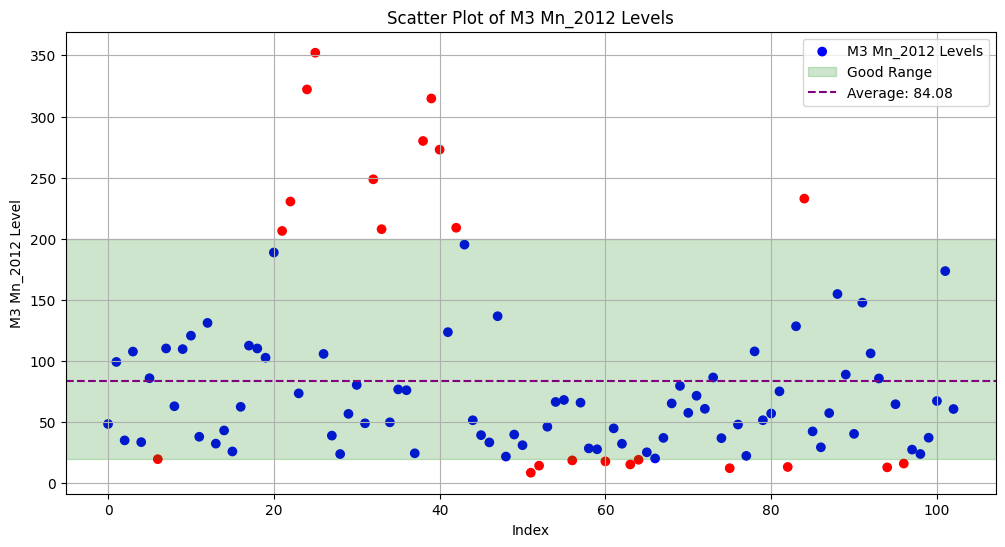

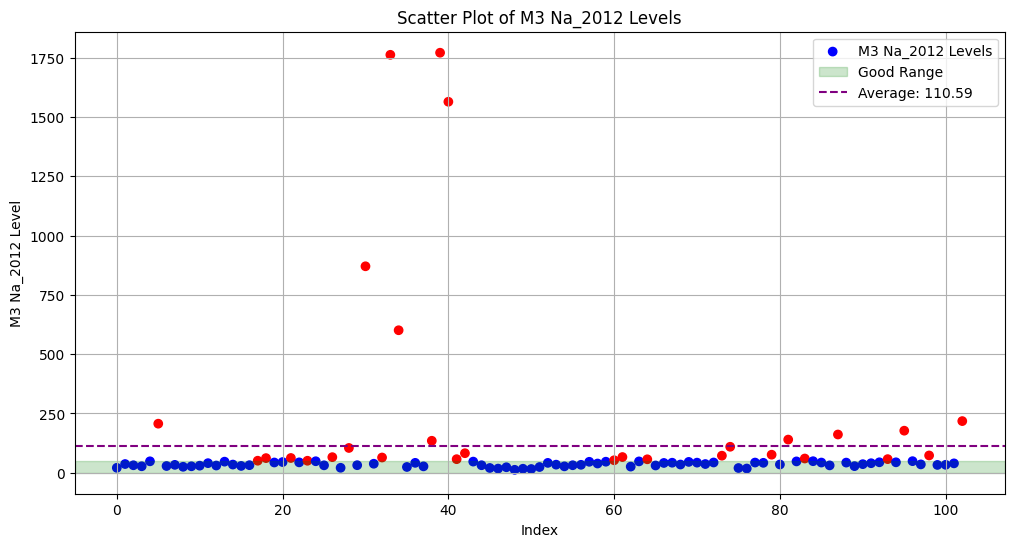

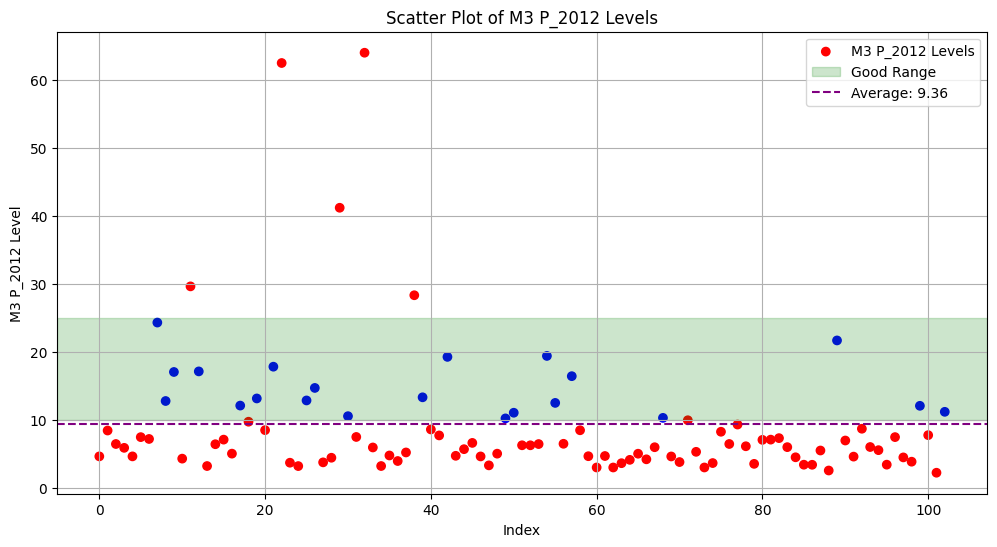

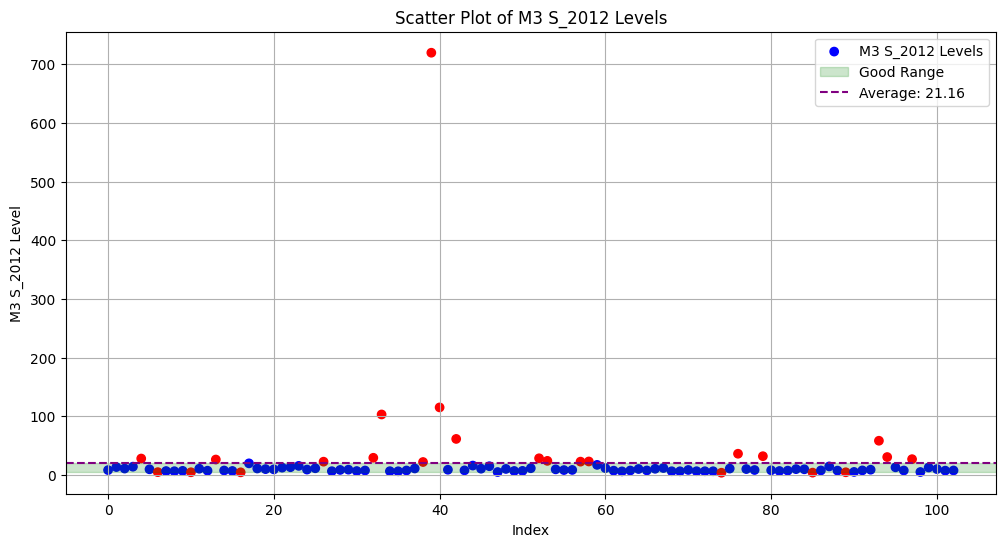

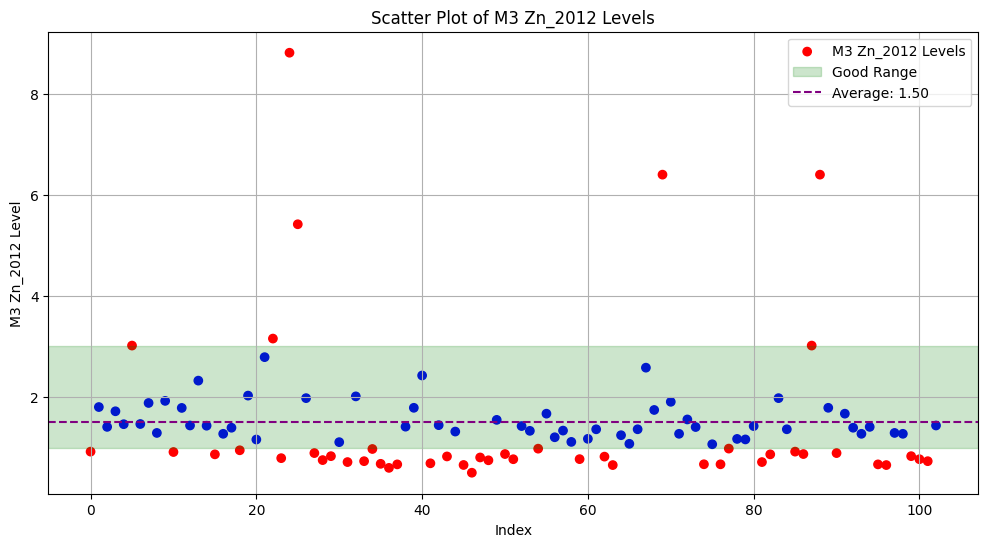

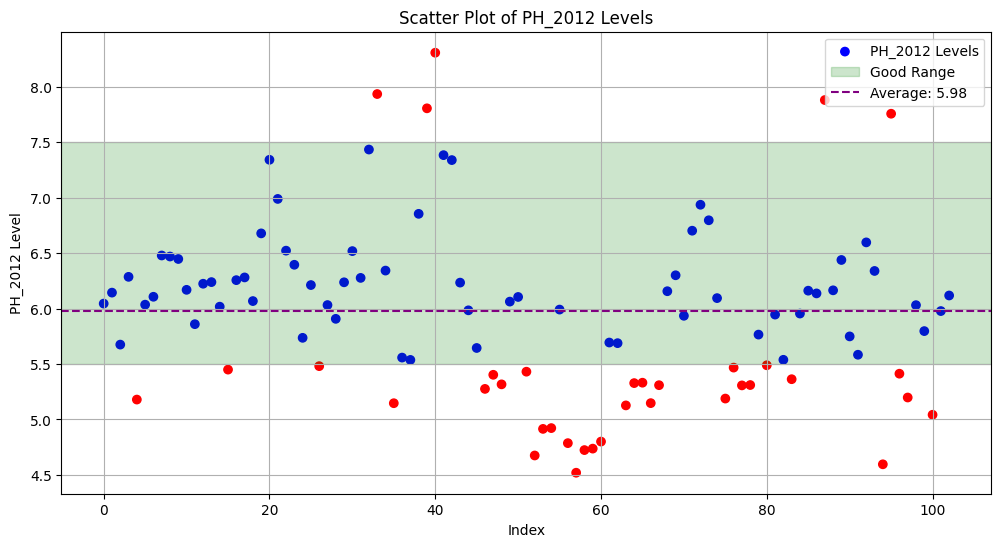

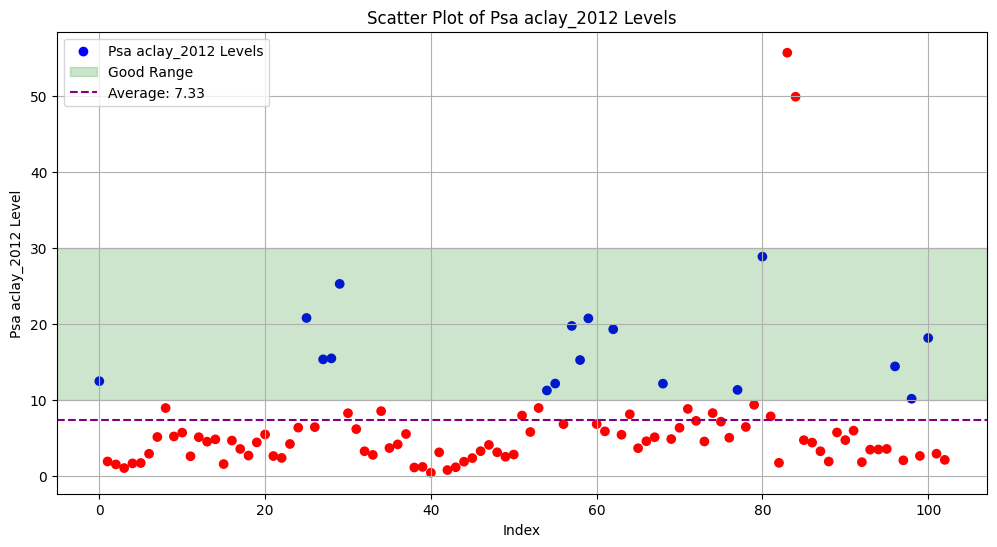

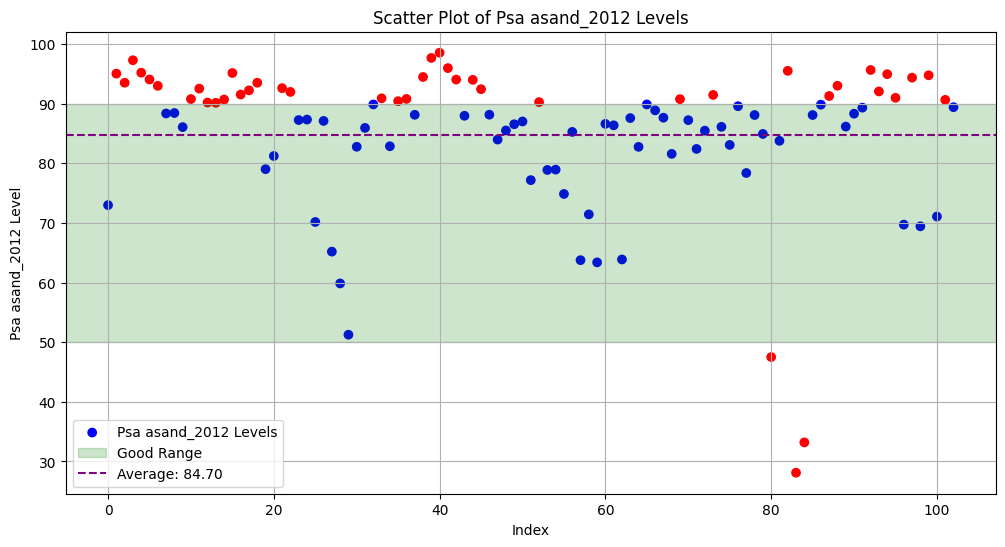

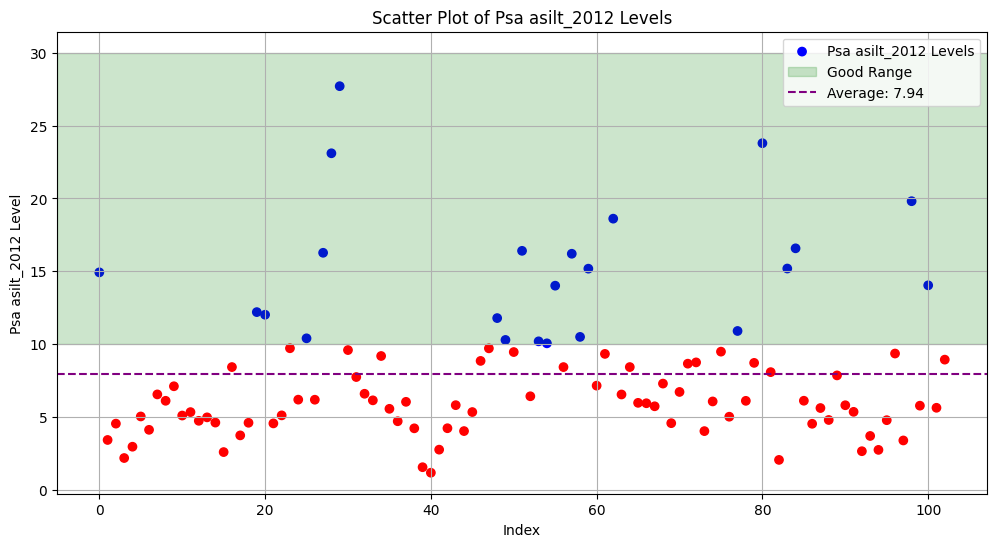

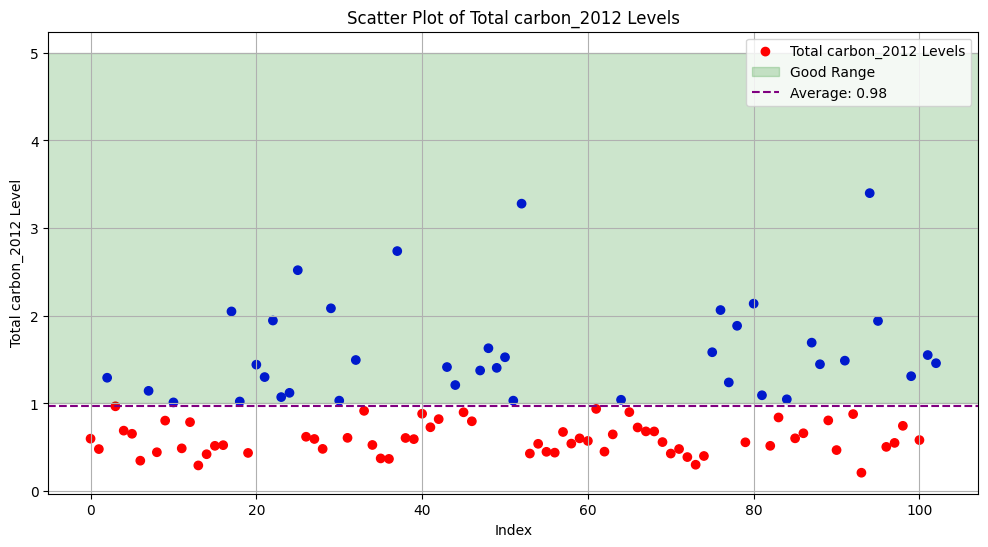

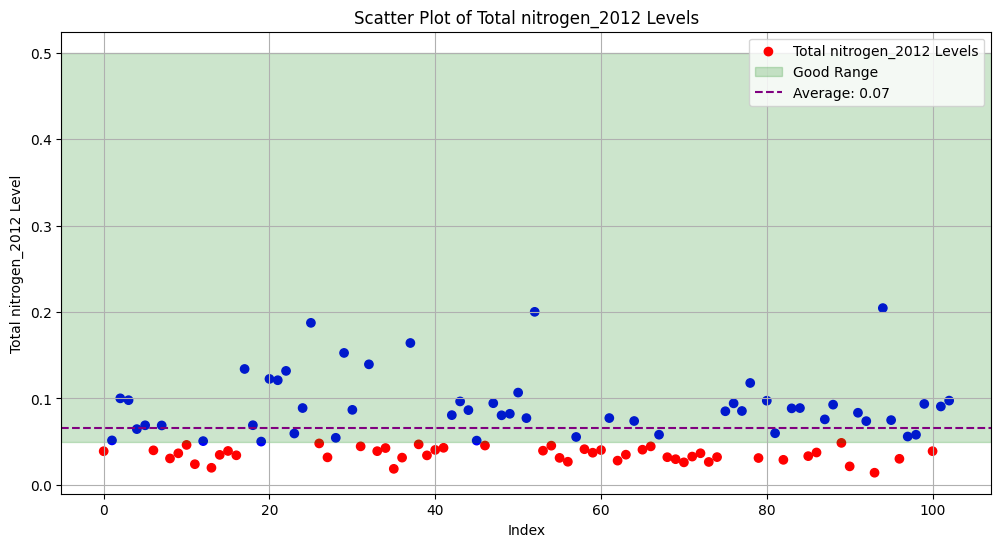

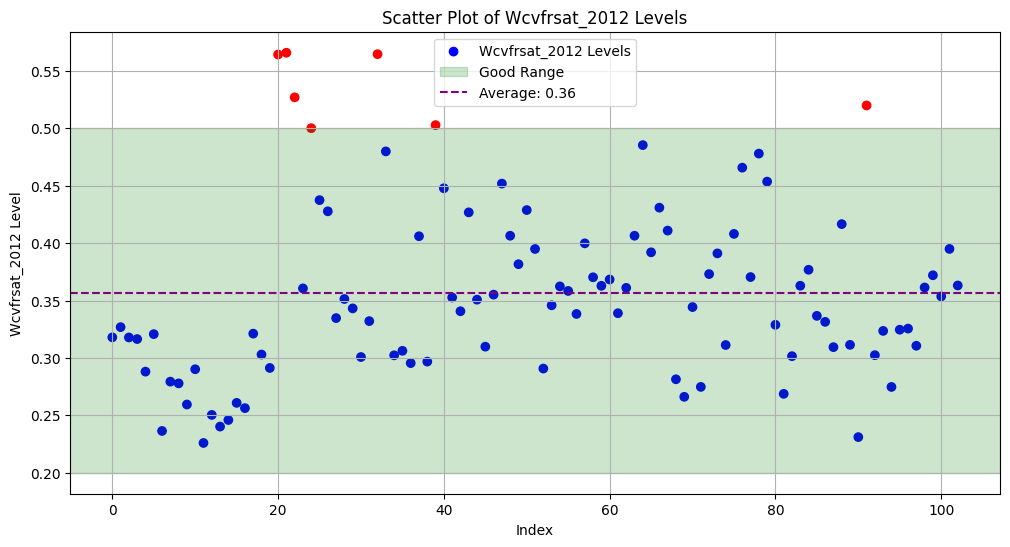

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk, Scrollbar
# Example DataFrame - Replace with your actual data
# df = pd.read_csv("your_dataset.csv")

# Features and Good Ranges
features = ['C % Inorg_2012',
       'C % Org_2012', 'ECEC_2012', 'EC_2012', 'Ksat_2012',
       'M3 Al_2012', 'M3 B_2012', 'M3 Ca_2012', 'M3 Cu_2012', 'M3 Fe_2012',
       'M3 K_2012', 'M3 Mg_2012', 'M3 Mn_2012', 'M3 Na_2012', 'M3 P_2012',
       'M3 S_2012', 'M3 Zn_2012', 'PH_2012', 'Psa aclay_2012',
       'Psa asand_2012', 'Psa asilt_2012',
       'Total carbon_2012', 'Total nitrogen_2012',
       'Wcvfrsat_2012']

good_ranges = {
    'M3 Al_2012': (0.0, 0.5),
    'M3 B_2012': (0.3, 3.0),
    'M3 Ca_2012': (200.0, 1500.0),
    'M3 Cu_2012':(1.0,5.0),
    'M3 Fe_2012':(50.0,150.0),
    'M3 K_2012':(50.0,200.0),
    'M3 Mg_2012':(50.0,300.0),
    'M3 Mn_2012':(20.0,200.0),
    'M3 Na_2012':(0.0,50.0),
    'M3 P_2012':(10.0,25.0),
    'M3 S_2012':(5.0,20.0),
    'M3 Zn_2012':(1.0,3.0),
    'PH_2012':(5.5,7.5),
    'Psa asand_2012':(50.0,90.0),
    'Psa asilt_2012':(10.0,30.0),
    'Psa aclay_2012':(10.0,30.0),
    'Wcvfrsat_2012':(0.2,0.5),
    'Ksat_2012':(5.0,25.0),
    'Total nitrogen_2012':(0.05,0.5),
    'Total carbon_2012':(1.0,5.0),
    'ECEC_2012':(5.0,30.0),
    'EC_2012':(0.0,1.2),
    'C % Inorg_2012':(0.0,0.2),
    'C % Org_2012':(1.0,4.0)
}

# Function to classify soil levels
def classify_soil(feature,value, good_min, good_max):
  if feature in ['C % Inorg_2012',
       'C % Org_2012', 'ECEC_2012', 'EC_2012',
       'M3 Al_2012', 'M3 B_2012', 'M3 Ca_2012', 'M3 Cu_2012', 'M3 Fe_2012',
       'M3 K_2012', 'M3 Mg_2012', 'M3 Mn_2012', 'M3 Na_2012', 'M3 P_2012',
       'M3 S_2012', 'M3 Zn_2012','Total carbon_2012', 'Total nitrogen_2012',
       ]:

    if value < good_min:  # Between 80% and 100% of minimum
        return f"{feature} Deficient Soil"
    elif good_min <= value <= good_max:  # Within good range
        return f"Normal {feature} Value in Soil"
    else:  # Greater than 120% of max
        return f"{feature} Toxic Soil"
  if feature in ['Ksat_2012','Psa aclay_2012']:
      if value < good_min:  # Between 80% and 100% of minimum
          return f"Poor Drainage Soil"
      elif good_min <= value <= good_max:  # Within good range
          return f"Normal Drainage Soil"
      else:  # Greater than 120% of max
          return f"Rapid Water Movement in Soil"
  if feature=='PH_2012':
      if value < good_min:  # Between 80% and 100% of minimum
          return f"Acidic Soil"
      elif good_min <= value <= good_max:  # Within good range
          return f"Neutral Soil"
      else:  # Greater than 120% of max
          return f"Alkaline Soil"
  if feature=='Wcvfrsat_2012':
      if value < good_min:  # Between 80% and 100% of minimum
          return f"Low Water Saturation in Soil"
      elif good_min <= value <= good_max:  # Within good range
          return f"Normal Water Saturation in Soil"
      else:  # Greater than 120% of max
          return f"High Water Saturation in Soil"
  if feature=='Psa asilt_2012':
      if value < good_min:  # Between 80% and 100% of minimum
          return f"Low Fertility in Soil"
      elif good_min <= value <= good_max:  # Within good range
          return f"Good Fertility in Soil"
      else:  # Greater than 120% of max
          return f"High Fertlity But Poor Drainange Soil"
  if feature=='Psa asand_2012':
      if value < good_min:  # Between 80% and 100% of minimum
          return f"Low Fertility and Poor Drainange in Soil"
      elif good_min <= value <= good_max:  # Within good range
          return f"Good Fertility and Drainage in Soil"
      else:  # Greater than 120% of max
          return f"High Fertlity Soil"
# Create scatter plots and calculate averages

units = {
    'M3 Al_2012': 'mg/kg',
    'M3 B_2012': 'mg/kg',
    'M3 Ca_2012': 'mg/kg',
    'M3 Cu_2012': 'mg/kg',
    'PH_2012': '',
    'EC_2012':'dS/m',
    'M3 Fe_2012':'mg/kg',
    'M3 K_2012':'mg/kg',
    'M3 Mg_2012':'mg/kg',
    'M3 Mn_2012':'mg/kg',
    'M3 Na_2012':'mg/kg',
    'M3 P_2012':'mg/kg',
    'M3 S_2012':'mg/kg',
    'M3 Zn_2012':'mg/kg',
    'Psa asand_2012':'%',
    'Psa asilt_2012':'%',
    'Psa aclay_2012':'%',
    'Wcvfrsat_2012':'m3/m3',
    'Ksat_2012':'cm/hr',
    'Total nitrogen_2012':'%',
    'Total carbon_2012':'%',
    'C % Inorg_2012':'%',
    'C % Org_2012':'%',
    'ECEC_2012':'cmol/kg'
}
results = []
for feature in features:
    values = df[feature]
    avg_value = np.mean(values)
    good_min, good_max = good_ranges[feature]
    classification = classify_soil(feature, avg_value, good_min, good_max)
    feature_with_unit = f"{feature} ({units.get(feature, '')})"

    results.append((feature_with_unit, avg_value, classification))

# GUI: Display average and classification with Tkinter
def show_gui():
    root = tk.Tk()
    root.title("Soil Feature Averages and Classifications")
    root.geometry("600x400")  # GUI window size

    # Treeview Table
    tree = ttk.Treeview(root, columns=("Feature", "Average", "Classification"), show="headings")
    tree.heading("Feature", text="Feature")
    tree.heading("Average", text="Average Value")
    tree.heading("Classification", text="Classification")

    # Add data to the table
    for feature, avg, cls in results:
        tree.insert("", "end", values=(feature, f"{avg:.2f}", cls))

    # Add a scrollbar
    scrollbar = Scrollbar(root, orient="vertical", command=tree.yview)
    tree.configure(yscroll=scrollbar.set)
    scrollbar.pack(side="right", fill="y")

    # Place the table
    tree.pack(expand=True, fill="both")

    # Close button
    close_button = tk.Button(root, text="Close", command=root.destroy)
    close_button.pack(pady=10)

    root.mainloop()


# Show GUI with averages and classifications
show_gui()